<a href="https://colab.research.google.com/github/gf4417/MLforIMG-CW/blob/gf4417/Copy_of_CW_Brain_Age_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [1]:
! pip install SimpleITK==1.2.4 

     |████████████████████████████████| 42.5MB 76kB/s 


### Downloading the data

In [2]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

--2021-02-28 08:40:59--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  37.1MB/s    in 13s     

2021-02-28 08:41:12 (35.2 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating

### Setting data directory

In [3]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [4]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

subject_id  age  gender_code gender_text
0   CC110033   24            1        MALE
1   CC110037   18            1        MALE
2   CC110045   24            2      FEMALE
3   CC110056   22            2      FEMALE
4   CC110062   20            1        MALE

Let's have a look at some population statistics.

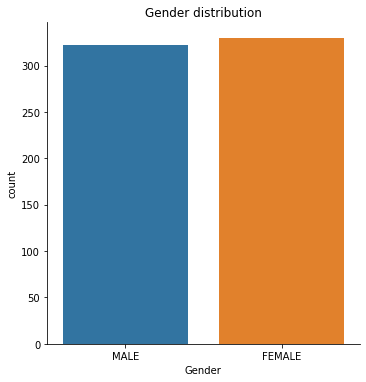

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


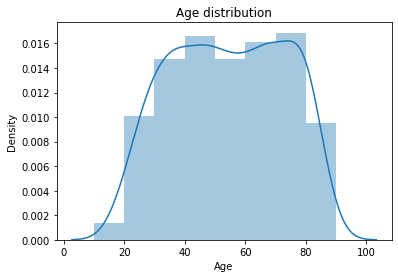

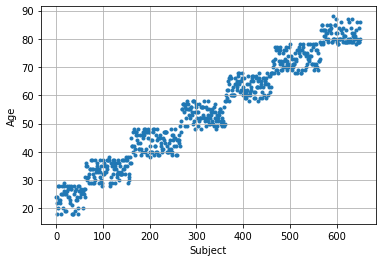

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [6]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


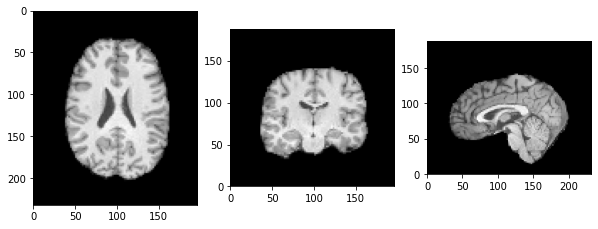

Brain mask


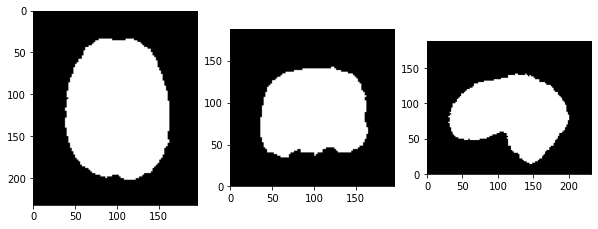

In [7]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [9]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [10]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [11]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64] # Original: [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.002 # Original: 0.001
batch_size = 2
val_interval = 10 # Original: 10

# Best params for ONet so far.
# num_epochs = 80
# learning_rate = 0.002
# batch_size = 2
# val_interval = 10
# Scheduler: patience=6, factor=0.5, threshold=0.0002

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [12]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [13]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


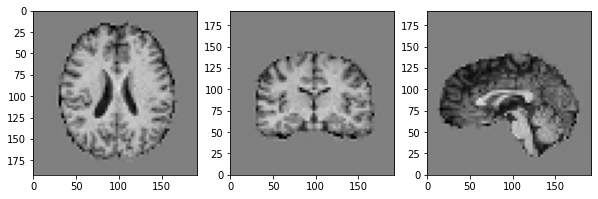

Segmentation


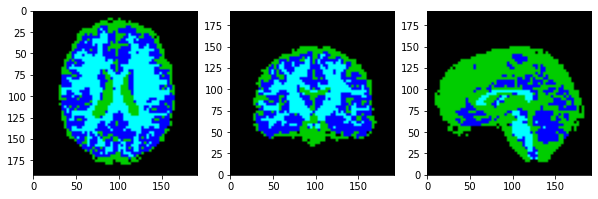

Mask


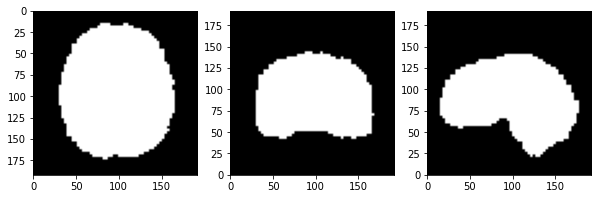

In [14]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [15]:
########################################
# BUILD A BETTER MODEL HERE
########################################

class UNet3D(nn.Module):

    def __init__(self, num_classes):
        super(UNet3D, self).__init__()

        self.enc_block_1 = self.make_block(1, 8)
        self.downsample_1 = nn.Conv3d(8, 8, kernel_size=2, stride=2, padding=0)
        self.enc_block_2 = self.make_block(8, 16)
        self.downsample_2 = nn.Conv3d(16, 16, kernel_size=2, stride=2, padding=0)

        self.bottleneck = self.make_block(16, 16)

        # Decoding blocks will also receive residual connections from encoding blocks.
        self.upsample_1 = nn.ConvTranspose3d(16, 16, kernel_size=2, stride=2, padding=0)
        self.dec_block_1 = self.make_block(16, 8)
        self.upsample_2 = nn.ConvTranspose3d(8, 8, kernel_size=2, stride=2, padding=0)
        self.dec_block_2 = self.make_block(16, 8)
        self.final = nn.Conv3d(8, num_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        enc1 = self.enc_block_1(x)
        ds1 = self.downsample_1(enc1)
        enc2 = self.enc_block_2(ds1)
        ds2 = self.downsample_2(enc2)

        bn = self.bottleneck(ds2)

        us1 = self.upsample_1(bn)
        dec1 = self.dec_block_1(us1)
        us2 = self.upsample_2(dec1)
        dec2 = self.dec_block_2(torch.cat((us2, enc1), dim=1))
        out = self.final(dec2)
        
        return out # cross-entropy loss expects raw logits and applies softmax

    def make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(out_channels),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

class ONet3D(nn.Module):
  def __init__(self, num_classes):
    super(ONet3D, self).__init__()
    self.enc_block_1 = self.make_block(1, 8)
    self.downsample_1 = nn.Conv3d(8, 8, kernel_size=2, stride=2, padding=0)
    self.enc_block_2 = self.make_block(8, 16)
    self.downsample_2 = nn.Conv3d(16, 16, kernel_size=2, stride=2, padding=0)
    self.enc_block_3 = self.make_block(16, 32)
    self.downsample_3 = nn.Conv3d(32, 32, kernel_size=2, stride=2, padding=0)
    self.bottleneck = self.make_block(32, 32)
    # Decoding blocks will also receive residual connections from encoding blocks.
    self.upsample_1 = nn.ConvTranspose3d(32, 32, kernel_size=2, stride=2, padding=0)
    self.dec_block_1 = self.make_block(32, 16)
    self.upsample_2 = nn.ConvTranspose3d(16, 16, kernel_size=2, stride=2, padding=0)
    self.dec_block_2 = self.make_block(32, 8, mid_channels=16)
    self.upsample_3 = nn.ConvTranspose3d(8, 8, kernel_size=2, stride=2, padding=0)
    self.dec_block_3 = self.make_block(16, 4, mid_channels=8)
    self.final = nn.Conv3d(5, num_classes, kernel_size=1, stride=1, padding=0)
  
  def forward(self, x):
    enc1 = self.enc_block_1(x)
    ds1 = self.downsample_1(enc1)
    enc2 = self.enc_block_2(ds1)
    ds2 = self.downsample_2(enc2)
    enc3 = self.enc_block_3(ds2)
    ds3 = self.downsample_3(enc3)
    bn = self.bottleneck(ds3)
    us1 = self.upsample_1(bn)
    dec1 = self.dec_block_1(us1)
    us2 = self.upsample_2(dec1)
    dec2 = self.dec_block_2(torch.cat((us2, enc2), dim=1))
    us3 = self.upsample_3(dec2)
    dec3 = self.dec_block_3(torch.cat((us3, enc1), dim=1))
    out = self.final(torch.cat((dec3, x), dim=1))
    return out
  def make_block(self, in_channels, out_channels, mid_channels=None):
    if mid_channels is None:
      mid_channels = out_channels
    return nn.Sequential(
      nn.Conv3d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
      nn.ReLU(),
      nn.BatchNorm3d(mid_channels),
      nn.Conv3d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
      nn.ReLU(),
    )

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

In [16]:
# Added Metrics #
import sklearn.metrics as sk
def dice_score(prd, seg, ignore=None):
  assert prd.max() == seg.max() and prd.min() == seg.min(), "Number of classes differ for segmentation and prediction." 
  if not ignore is None:
    f1_scores = sk.f1_score(prd.flatten(), seg.flatten(), average=None)
    return np.delete(f1_scores, ignore, 0).mean()
  return sk.f1_score(prd.flatten(), seg.flatten(), average=None ) #'weighted')

In [17]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.303965
Current lr = [0.002]
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.300131


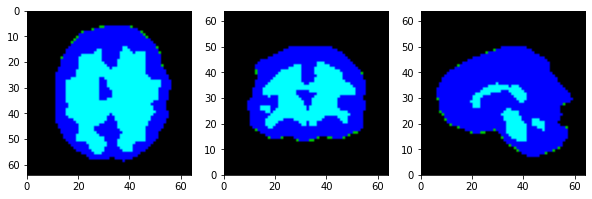

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.233976
Current lr = [0.002]
+ TRAINING 	Epoch: 3 	Loss: 0.191957
Current lr = [0.002]
+ TRAINING 	Epoch: 4 	Loss: 0.221920
Current lr = [0.002]
+ TRAINING 	Epoch: 5 	Loss: 0.201008
Current lr = [0.002]
+ TRAINING 	Epoch: 6 	Loss: 0.166117
Current lr = [0.002]
+ TRAINING 	Epoch: 7 	Loss: 0.136571
Current lr = [0.002]
+ TRAINING 	Epoch: 8 	Loss: 0.154721
Current lr = [0.002]
+ TRAINING 	Epoch: 9 	Loss: 0.124347
Current lr = [0.002]
+ TRAINING 	Epoch: 10 	Loss: 0.134192
Current lr = [0.002]
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.137461


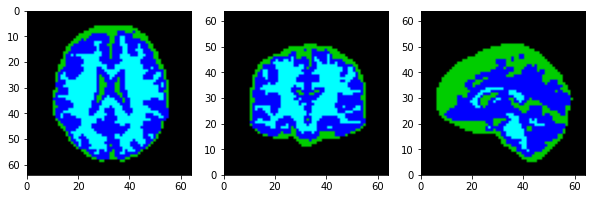

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.121318
Current lr = [0.002]
+ TRAINING 	Epoch: 12 	Loss: 0.116525
Current lr = [0.002]
+ TRAINING 	Epoch: 13 	Loss: 0.108685
Current lr = [0.002]
+ TRAINING 	Epoch: 14 	Loss: 0.110402
Current lr = [0.002]
+ TRAINING 	Epoch: 15 	Loss: 0.111771
Current lr = [0.002]
+ TRAINING 	Epoch: 16 	Loss: 0.100178
Current lr = [0.002]
+ TRAINING 	Epoch: 17 	Loss: 0.098687
Current lr = [0.002]
+ TRAINING 	Epoch: 18 	Loss: 0.093085
Current lr = [0.002]
+ TRAINING 	Epoch: 19 	Loss: 0.084100
Current lr = [0.002]
+ TRAINING 	Epoch: 20 	Loss: 0.086883
Current lr = [0.002]
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.100713


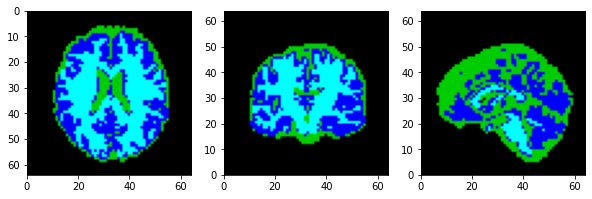

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.091371
Current lr = [0.002]
+ TRAINING 	Epoch: 22 	Loss: 0.093925
Current lr = [0.002]
+ TRAINING 	Epoch: 23 	Loss: 0.081938
Current lr = [0.002]
+ TRAINING 	Epoch: 24 	Loss: 0.102049
Current lr = [0.002]
+ TRAINING 	Epoch: 25 	Loss: 0.135441
Current lr = [0.002]
+ TRAINING 	Epoch: 26 	Loss: 0.165667
Current lr = [0.002]
+ TRAINING 	Epoch: 27 	Loss: 0.090374
Current lr = [0.002]
+ TRAINING 	Epoch: 28 	Loss: 0.080518
Current lr = [0.002]
+ TRAINING 	Epoch: 29 	Loss: 0.108048
Current lr = [0.002]
+ TRAINING 	Epoch: 30 	Loss: 0.088573
Current lr = [0.002]
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.099737


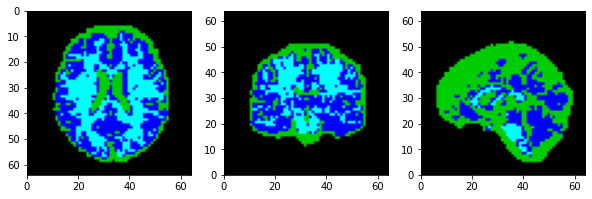

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.075982
Current lr = [0.002]
+ TRAINING 	Epoch: 32 	Loss: 0.085567
Current lr = [0.002]
+ TRAINING 	Epoch: 33 	Loss: 0.102283
Current lr = [0.002]
+ TRAINING 	Epoch: 34 	Loss: 0.086071
Current lr = [0.002]
+ TRAINING 	Epoch: 35 	Loss: 0.106154
Current lr = [0.002]
+ TRAINING 	Epoch: 36 	Loss: 0.072459
Current lr = [0.002]
+ TRAINING 	Epoch: 37 	Loss: 0.079928
Current lr = [0.002]
+ TRAINING 	Epoch: 38 	Loss: 0.068650
Current lr = [0.002]
+ TRAINING 	Epoch: 39 	Loss: 0.072317
Current lr = [0.002]
+ TRAINING 	Epoch: 40 	Loss: 0.065118
Current lr = [0.002]
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.083906


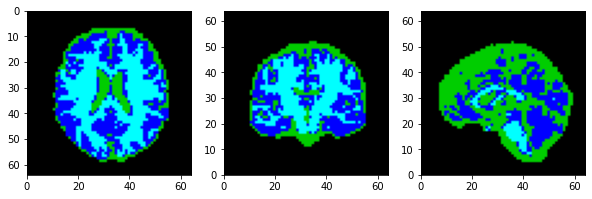

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.084143
Current lr = [0.002]
+ TRAINING 	Epoch: 42 	Loss: 0.081877
Current lr = [0.002]
+ TRAINING 	Epoch: 43 	Loss: 0.081235
Current lr = [0.002]
+ TRAINING 	Epoch: 44 	Loss: 0.065057
Current lr = [0.002]
+ TRAINING 	Epoch: 45 	Loss: 0.093214
Current lr = [0.002]
+ TRAINING 	Epoch: 46 	Loss: 0.067793
Current lr = [0.002]
+ TRAINING 	Epoch: 47 	Loss: 0.081821
Current lr = [0.002]
+ TRAINING 	Epoch: 48 	Loss: 0.102612
Current lr = [0.002]
+ TRAINING 	Epoch: 49 	Loss: 0.096448
Current lr = [0.002]
+ TRAINING 	Epoch: 50 	Loss: 0.121906
Current lr = [0.002]
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.092128


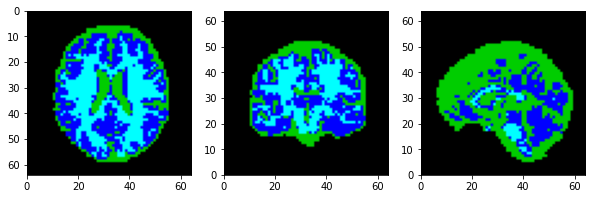

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.071822
Current lr = [0.002]
+ TRAINING 	Epoch: 52 	Loss: 0.076362
Current lr = [0.002]
+ TRAINING 	Epoch: 53 	Loss: 0.081186
Current lr = [0.001]
+ TRAINING 	Epoch: 54 	Loss: 0.077773
Current lr = [0.001]
+ TRAINING 	Epoch: 55 	Loss: 0.070714
Current lr = [0.001]
+ TRAINING 	Epoch: 56 	Loss: 0.075767
Current lr = [0.001]
+ TRAINING 	Epoch: 57 	Loss: 0.067754
Current lr = [0.001]
+ TRAINING 	Epoch: 58 	Loss: 0.074329
Current lr = [0.001]
+ TRAINING 	Epoch: 59 	Loss: 0.101172
Current lr = [0.001]
+ TRAINING 	Epoch: 60 	Loss: 0.059942
Current lr = [0.001]
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.079412


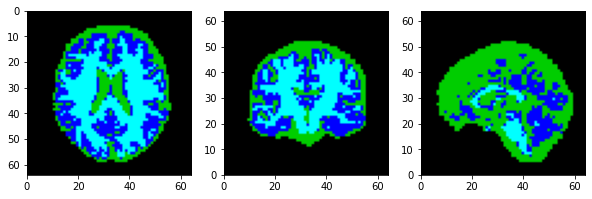

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.062947
Current lr = [0.001]
+ TRAINING 	Epoch: 62 	Loss: 0.080341
Current lr = [0.001]
+ TRAINING 	Epoch: 63 	Loss: 0.073607
Current lr = [0.001]
+ TRAINING 	Epoch: 64 	Loss: 0.075218
Current lr = [0.0005]
+ TRAINING 	Epoch: 65 	Loss: 0.069584
Current lr = [0.0005]
+ TRAINING 	Epoch: 66 	Loss: 0.084542
Current lr = [0.0005]
+ TRAINING 	Epoch: 67 	Loss: 0.072426
Current lr = [0.0005]
+ TRAINING 	Epoch: 68 	Loss: 0.094962
Current lr = [0.0005]
+ TRAINING 	Epoch: 69 	Loss: 0.059503
Current lr = [0.0005]
+ TRAINING 	Epoch: 70 	Loss: 0.067133
Current lr = [0.0005]
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.078060


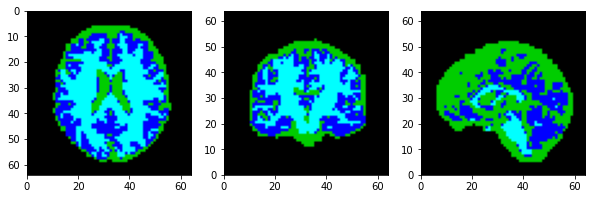

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.059767
Current lr = [0.0005]
+ TRAINING 	Epoch: 72 	Loss: 0.063129
Current lr = [0.00025]
+ TRAINING 	Epoch: 73 	Loss: 0.057205
Current lr = [0.00025]
+ TRAINING 	Epoch: 74 	Loss: 0.076897
Current lr = [0.00025]
+ TRAINING 	Epoch: 75 	Loss: 0.054872
Current lr = [0.00025]
+ TRAINING 	Epoch: 76 	Loss: 0.063346
Current lr = [0.00025]
+ TRAINING 	Epoch: 77 	Loss: 0.067942
Current lr = [0.00025]
+ TRAINING 	Epoch: 78 	Loss: 0.058588
Current lr = [0.00025]
+ TRAINING 	Epoch: 79 	Loss: 0.076265
Current lr = [0.000125]
+ TRAINING 	Epoch: 80 	Loss: 0.058461
Current lr = [0.000125]
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.076392


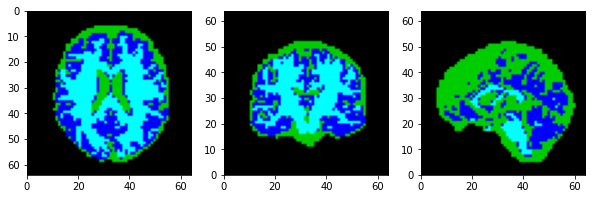

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.097213
Current lr = [0.000125]
+ TRAINING 	Epoch: 82 	Loss: 0.054249
Current lr = [0.000125]
+ TRAINING 	Epoch: 83 	Loss: 0.063531
Current lr = [0.000125]
+ TRAINING 	Epoch: 84 	Loss: 0.062956
Current lr = [0.000125]
+ TRAINING 	Epoch: 85 	Loss: 0.058712
Current lr = [0.000125]
+ TRAINING 	Epoch: 86 	Loss: 0.088890
Current lr = [6.25e-05]
+ TRAINING 	Epoch: 87 	Loss: 0.057457
Current lr = [6.25e-05]
+ TRAINING 	Epoch: 88 	Loss: 0.068723
Current lr = [6.25e-05]
+ TRAINING 	Epoch: 89 	Loss: 0.064003
Current lr = [6.25e-05]
+ TRAINING 	Epoch: 90 	Loss: 0.056785
Current lr = [6.25e-05]
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.076180


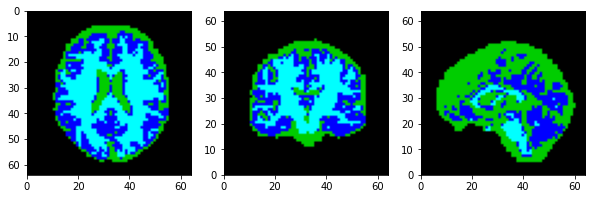

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.070086
Current lr = [6.25e-05]
+ TRAINING 	Epoch: 92 	Loss: 0.056916
Current lr = [6.25e-05]
+ TRAINING 	Epoch: 93 	Loss: 0.064408
Current lr = [3.125e-05]
+ TRAINING 	Epoch: 94 	Loss: 0.067298
Current lr = [3.125e-05]
+ TRAINING 	Epoch: 95 	Loss: 0.056655
Current lr = [3.125e-05]
+ TRAINING 	Epoch: 96 	Loss: 0.065103
Current lr = [3.125e-05]
+ TRAINING 	Epoch: 97 	Loss: 0.066829
Current lr = [3.125e-05]
+ TRAINING 	Epoch: 98 	Loss: 0.063025
Current lr = [3.125e-05]
+ TRAINING 	Epoch: 99 	Loss: 0.064948
Current lr = [3.125e-05]
+ TRAINING 	Epoch: 100 	Loss: 0.067856
Current lr = [1.5625e-05]
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.076105


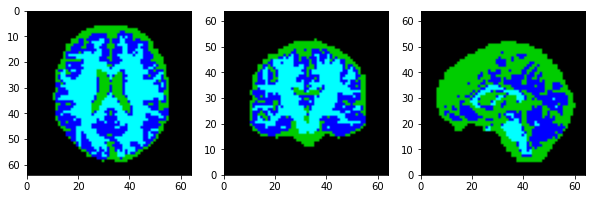

--------------------------------------------------

Finished TRAINING.


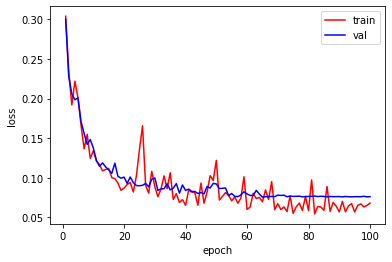

In [18]:
torch.manual_seed(rnd_seed) #fix random seed

#model = ONet3D(num_classes=num_classes).to(device)
model = UNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.5, threshold=0.0002)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    model.train()
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    model.eval()
    loss_val = 0
    sum_pts = 0
    with torch.no_grad():
        for data_sample in dataloader_val:
            img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
            prd = model(img)
            loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
            sum_pts += np.prod(img_size)
            
        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        scheduler.step(loss_val)
        print(f'Current lr = {scheduler._last_lr}')

        if epoch == 1 or epoch % val_interval == 0:
            print('--------------------------------------------------')
            print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
            prd = torch.argmax(prd, dim=1)
            prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
            display_image(sitk.LabelToRGB(prediction))
            print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [19]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]#[:5]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]#[:5]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]#[:5]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:24<00:00,  5.89it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


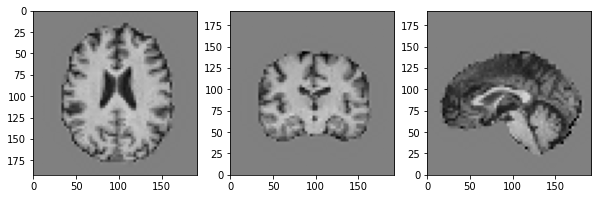

Segmentation


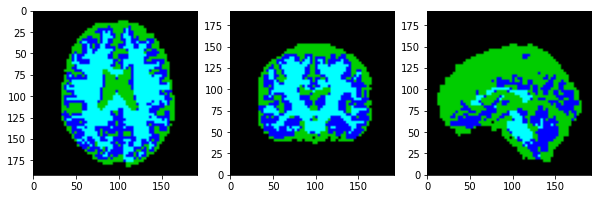

Mask


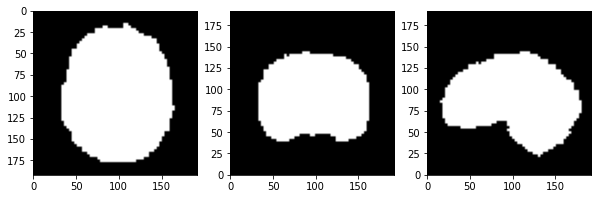

In [20]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

In [21]:
# Performance metrics.
# Cross entropy used in back-propagation since gradients are more straightforward.
def get_dice_scores(prd, seg):
    return sk.f1_score(prd.flatten(), seg.flatten(), average=None)

START TESTING...
+ TESTING 	Loss: 0.083005


Reference segmentation


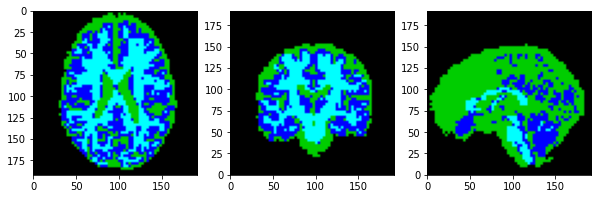

Predicted segmentation


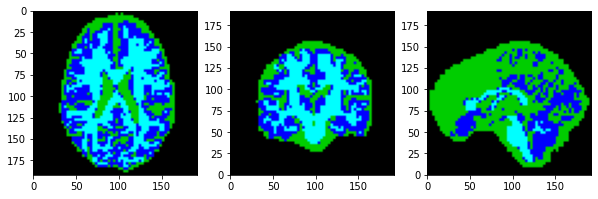


Finished TESTING.


In [22]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

#model = ONet3D(num_classes=num_classes)
model = UNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()

print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0

# For each class, store dice scores across testing dataset.
dice_scores = np.zeros((len(dataloader_test), num_classes))

with torch.no_grad():
    for i, data_sample in enumerate(dataloader_test):
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)
        class_scores = get_dice_scores(prd.cpu(), seg.cpu())
        dice_scores[i] = class_scores

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))

        idx_test += 1

loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

Dice scores: [0.99114501 0.81786352 0.89828277 0.92977838]
Mean Dice score (excluding background): 0.8819748890764245


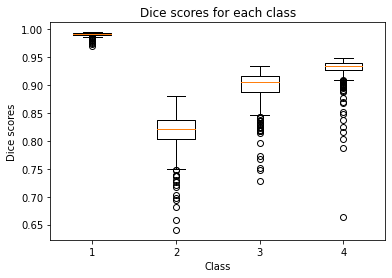

In [23]:
# Plot Dice score statistics.
mean_dice_scores = np.mean(dice_scores, axis=0)

# Exclude background.
dice_avg = mean_dice_scores[1:].mean()

print(f'Dice scores: {mean_dice_scores}')
print(f'Mean Dice score (excluding background): {dice_avg}')
plt.boxplot(dice_scores)
plt.title('Dice scores for each class')
plt.ylabel('Dice scores')
plt.xlabel('Class')
plt.show()

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [24]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        seg_img = sitk.GetArrayFromImage(seg)
        vols[0][idx] = np.sum(seg_img == 1)
        vols[1][idx] = np.sum(seg_img == 2)
        vols[2][idx] = np.sum(seg_img == 3)

Calculating Features: 100%|██████████| 500/500 [00:01<00:00, 442.12it/s]


Plot features versus age.

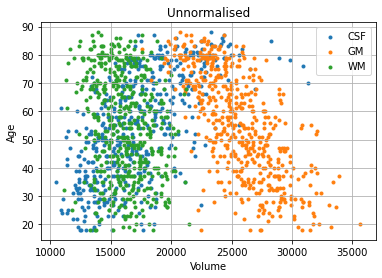

In [25]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [26]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
########################################
vols_normalised = vols / vols.sum(axis=0)

Plot normalised features versus age.

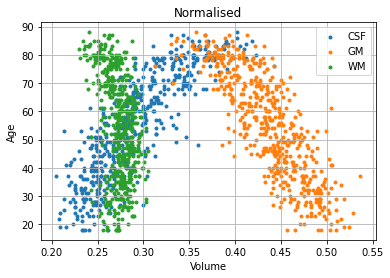

In [27]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

(500, 4)


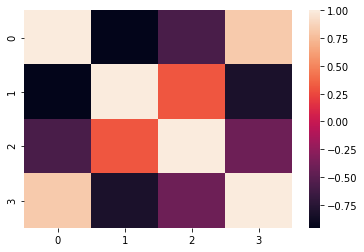

In [28]:
# Check colinearity of features
import seaborn as sns
X_data = np.concatenate((vols_normalised.T, meta_data_reg_train['age'].values.reshape(-1,1)), 1) #vols_normalised.T #np.concatenate((vols_normalised.T, meta_data_reg_train['age'].values.reshape(-1,1)), 1)
print(X_data.shape)

corr = pd.DataFrame(X_data).corr()
sns.heatmap(corr)

Final data for age regression

In [29]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

z_norm_X = ((X - X.mean(axis=0)) / X.std(axis=0))
log_y = np.log(1+y)

print(X.shape)
print(z_norm_X.shape)

print(y.shape)
print(log_y.shape)

(500, 3)
(500, 3)
(500, 1)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [30]:
########################################
# ADD YOUR CODE HERE
########################################
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
##########################################

In [31]:


models = {("Linear Regression", LinearRegression),
          ("Tree Regression", DecisionTreeRegressor),
          ("Support Vector Regression", SVR),
          #("Lasso Regression", Lasso),
          ("Ridge Regression", Ridge)
          }

def get_feature_importances(model, model_name):
  if model_name == "Linear Regression":
    return model.coef_
  elif model_name == "Tree Regression":
    return model.feature_importances_
  elif model_name == "Support Vector Regression":
    return model.coef_.flatten()
  elif model_name == "Lasso Regression":
    print(model.coef_)
    return model.coef_
  else:
    return model.coef_.flatten()

  return None

def initialise(model, model_name):
  if model_name == "Support Vector Regression":
    return model("linear")
  return model()

def repeated_k_fold(X, y, models, k, n):
  results = np.empty((len(models), 3), np.object)
  for i in range(len(models)):
    results[i][0] = []
    results[i][1] = []
  rkf = RepeatedKFold(n_splits=k, n_repeats=n)
  for train_idx, test_idx in rkf.split(X):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    for i, (n, m) in enumerate(models):
      model = m()
      model.fit(X_train, y_train.flatten())
      pred = model.predict(X_test)
      results[i][0] = np.concatenate((results[i][0], y_test.flatten()))
      results[i][1] = np.concatenate((results[i][1], pred.flatten()))
      results[i][2] = n 

  return results

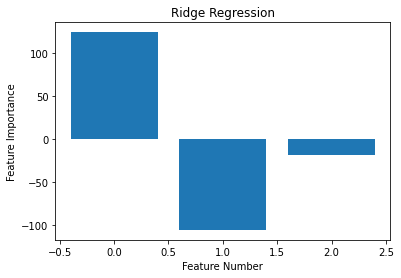

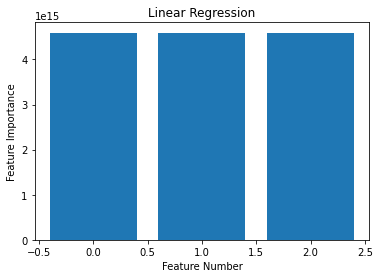

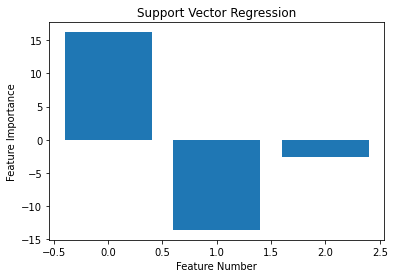

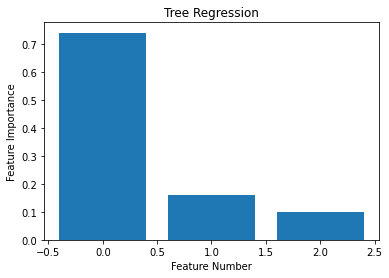

In [32]:
def evaluate_feature_importances(X, y, models):
  for i, (n, m) in enumerate(models):
      model = initialise(m, n)
      model.fit(X, y.flatten())
      feature_importance = get_feature_importances(model, n)
      fig, ax = plt.subplots()
      ax.bar([x for x in range(len(feature_importance))], feature_importance)
      ax.set_xlabel('Feature Number')
      ax.set_ylabel('Feature Importance')
      ax.set_title(n)
      plt.show()

evaluate_feature_importances(X, y, models)

Error calculation and plotting

In [33]:
def evaluate_results(actual, predicted, regression_name):
  print(regression_name)
  print('MAE: {0}'.format(mean_absolute_error(actual, predicted))) # Best: Smaller the better
  print('R2: {0}'.format(r2_score(actual, predicted))) # Best: 1.0 
  print('MVS: {0}'.format(explained_variance_score(actual, predicted))) # Best: 1.0
  print('MSE: {0}'.format(mean_squared_error(actual, predicted))) # Best: Smaller the better

  fig, ax = plt.subplots()
  ax.scatter(actual, predicted, marker='.')
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  ax.set_xlabel('Real Age')
  ax.set_ylabel('Predicted Age')
  ax.set_title(regression_name)
  plt.show() 

def evaluate_combinations(X, y, m, k, n, use_log=False):
  assert len(m) == 1, "Should only evaluate a model at a time."
  poly = PolynomialFeatures(3)
  fitted = poly.fit_transform(X)
  names = poly.get_feature_names()
  res = []
  for i in range(fitted.shape[1]):
    if use_log:
      results = repeated_k_fold(fitted[:, i].reshape(-1, 1), np.log(y+1), m, k, n)
      mae = mean_absolute_error(np.exp(results[0][0])-1, np.exp(results[0][1])-1)
    else:
      results = repeated_k_fold(fitted[:, i].reshape(-1, 1), y, m, k, n)
      mae = mean_absolute_error(results[0][0], results[0][1])
    res.append((names[i], mae))

  res.sort(key=lambda tup: tup[1])
  print(res)


In [34]:
evaluate_combinations(X, y, {("Linear Regression", LinearRegression)}, 2, 5)
evaluate_combinations(X, y, {("Support Vector Regression", SVR)}, 2, 5)
evaluate_combinations(X, y, {("Support Vector Regression", SVR)}, 2, 5, True)

[('x1^2 x2', 7.974494390807234), ('x0', 8.417200529686612), ('x0^2 x2', 8.48332837055819), ('x1^2', 8.512950784280948), ('x1^3', 8.545600688043525), ('x0^2 x1', 8.587850580713505), ('x1', 8.607692790216833), ('x1 x2', 8.741634477109113), ('x0 x2', 8.75262152411876), ('x0^2', 8.780395529010644), ('x0^3', 9.298358323301864), ('x0 x1', 9.399757070610002), ('x1 x2^2', 10.06708670417903), ('x0 x1 x2', 10.341813605237828), ('x0 x2^2', 11.596685711679457), ('x2', 13.931305836665945), ('x2^2', 13.967222216670828), ('x2^3', 14.086493187502827), ('x0 x1^2', 14.720628036851817), ('1', 15.882655999999999)]
[('x0', 8.313541863535653), ('x0^2', 8.344876047906487), ('x1^2 x2', 8.38108580874698), ('x0^2 x2', 8.428594006685051), ('x0^3', 8.443450310297893), ('x0^2 x1', 8.512815377098633), ('x1 x2', 8.658049821647106), ('x1^3', 9.153253956890143), ('x1^2', 9.166084432555884), ('x1', 9.171468371574068), ('x0 x2', 9.340149519999457), ('x0 x1', 9.620334761771653), ('x1 x2^2', 9.94282951508311), ('x0 x1 x2'

Ridge Regression
MAE: 11.035352894165971
R2: 0.503596247700595
MVS: 0.5035966719314618
MSE: 168.963643620946


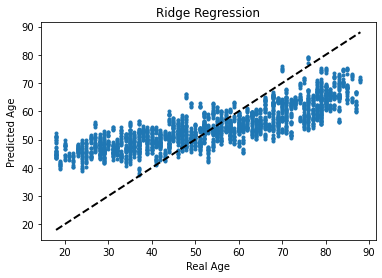

Linear Regression
MAE: 8.183446435546875
R2: 0.6922395683097826
MVS: 0.6922396347345963
MSE: 104.75409112010598


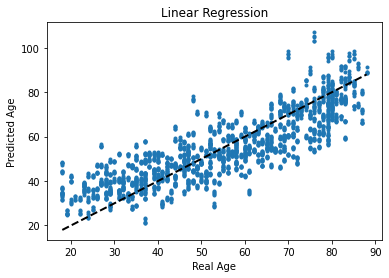

Support Vector Regression
MAE: 8.198676731360077
R2: 0.6983580204357743
MVS: 0.6997785528469356
MSE: 102.6715203100764


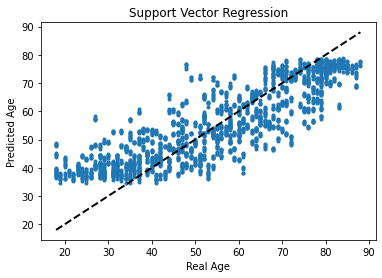

Tree Regression
MAE: 10.3648
R2: 0.47174566380871263
MVS: 0.4717637219860953
MSE: 179.8048


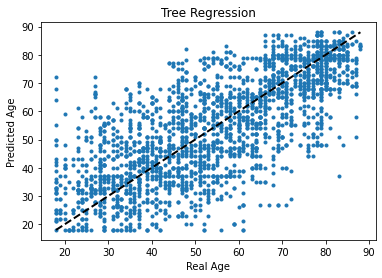

Log: Ridge Regression
MAE: 11.330456048473714
R2: 0.48570478654653404
MVS: 0.5101083756852489
MSE: 175.05345751193656


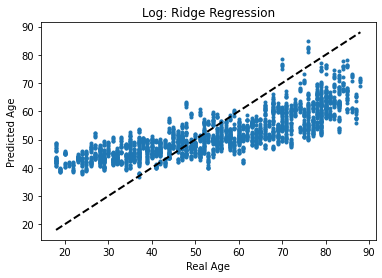

Log: Linear Regression
MAE: 9.100311444290297
R2: 0.6016832625167855
MVS: 0.6044504006067398
MSE: 135.5772331869467


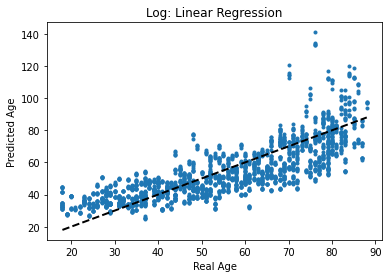

Log: Support Vector Regression
MAE: 7.631956325318835
R2: 0.722335539573635
MVS: 0.7225496945184802
MSE: 94.5101617793287


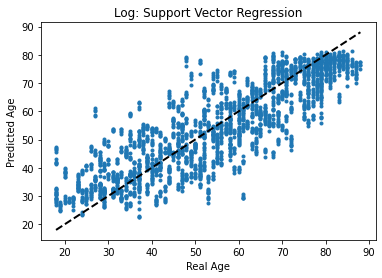

Log: Tree Regression
MAE: 10.6384
R2: 0.44941737805074755
MVS: 0.4496184341575108
MSE: 187.4048


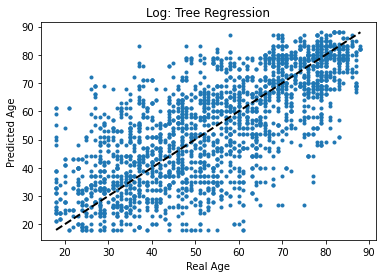

z_norm: Ridge Regression
MAE: 8.205712473511511
R2: 0.6914302473565466
MVS: 0.6914303370696223
MSE: 105.0295640924276


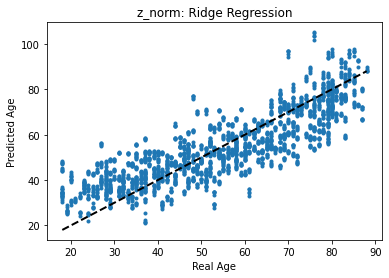

z_norm: Linear Regression
MAE: 8.237039296888616
R2: 0.688305168044024
MVS: 0.6883053269066035
MSE: 106.09326432596208


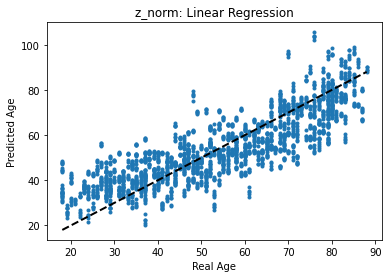

z_norm: Support Vector Regression
MAE: 8.837483095266924
R2: 0.6536921174825947
MVS: 0.6560138496310842
MSE: 117.87469650209863


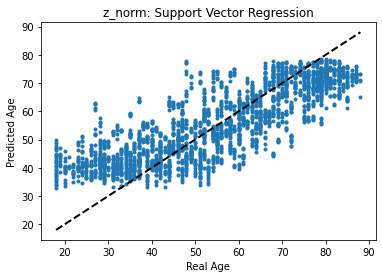

z_norm: Tree Regression
MAE: 10.3624
R2: 0.4751090087476231
MVS: 0.4751091610500354
MSE: 178.66


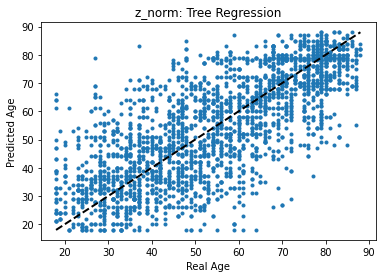

In [35]:
results = repeated_k_fold(X, y, models, 2, 5)
# applying logs to the expected output as the difference between age has a greater affect as one gets older
log_results = repeated_k_fold(X, log_y, models, 2, 5)
# Applyig z normalization to the input data
z_results = repeated_k_fold(z_norm_X, y, models, 2, 5)

for r in results:
  evaluate_results(r[0], r[1], r[2])

for r in log_results:
  evaluate_results(np.exp(r[0]) - 1, np.exp(r[1]) - 1, "Log: " + r[2])

for r in z_results:
  evaluate_results(r[0], r[1], "z_norm: " + r[2])

0: Ridge Regression
MAE: 12.326950229528828
R2: 0.3887397676462778
MVS: 0.3887410894039336
MSE: 208.05796809685953


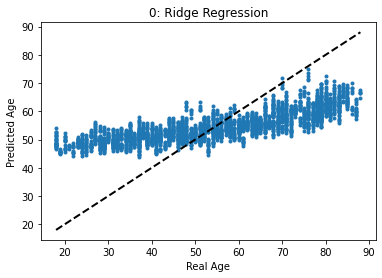

0: Linear Regression
MAE: 8.351701749128464
R2: 0.6837507516624215
MVS: 0.6837528067683042
MSE: 107.6434757875756


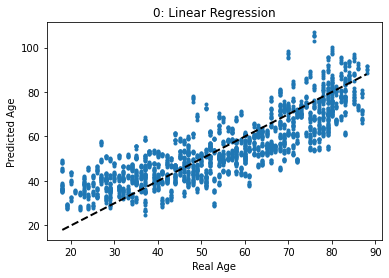

0: Support Vector Regression
MAE: 8.369751528665628
R2: 0.684082740578389
MVS: 0.6864769393914192
MSE: 107.53047491555596


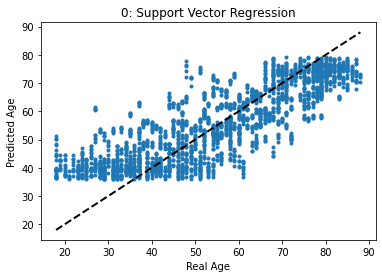

0: Tree Regression
MAE: 10.8816
R2: 0.4244096980018265
MVS: 0.4244871823241676
MSE: 195.9168


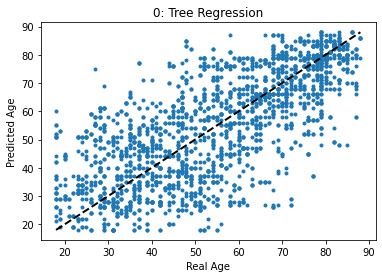

1: Ridge Regression
MAE: 13.044289042674047
R2: 0.32230312002571915
MVS: 0.32230322448101056
MSE: 230.67137099708552


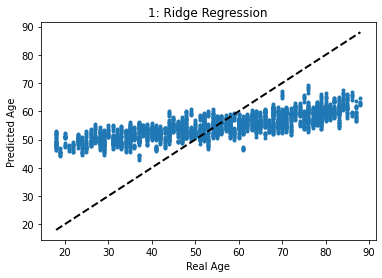

1: Linear Regression
MAE: 8.592214725632166
R2: 0.667656493848285
MVS: 0.6676565534239669
MSE: 113.12156580815869


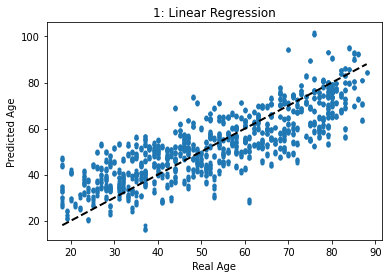

1: Support Vector Regression
MAE: 9.182659941202342
R2: 0.6400574799538667
MVS: 0.6401913233597231
MSE: 122.51559219564136


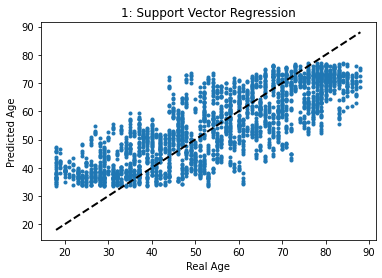

1: Tree Regression
MAE: 11.5564
R2: 0.3772817378043696
MVS: 0.3774470371592853
MSE: 211.958


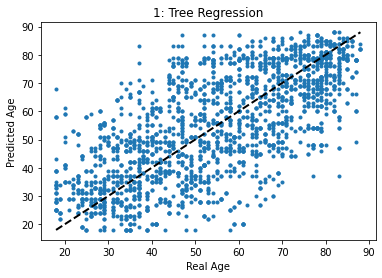

2: Ridge Regression
MAE: 15.759870756163027
R2: 0.011726158928651809
MVS: 0.011726159372271616
MSE: 336.38413954205487


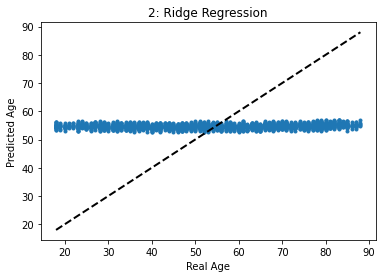

2: Linear Regression
MAE: 13.967708666413271
R2: 0.15554358299159543
MVS: 0.15554457396704757
MSE: 287.4322211222335


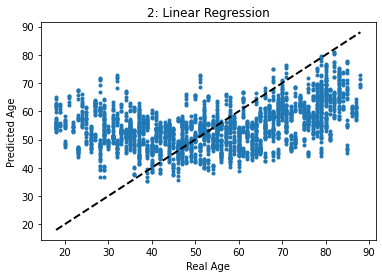

2: Support Vector Regression
MAE: 13.754457707890472
R2: 0.12392976574208092
MVS: 0.14627987933831577
MSE: 298.1927879521613


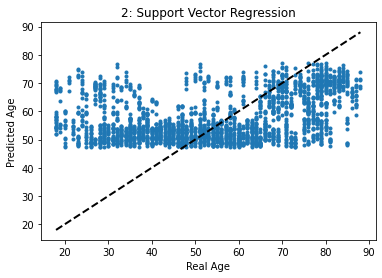

2: Tree Regression
MAE: 17.5776
R2: -0.5034292897681372
MVS: -0.5034123202709611
MSE: 511.7304


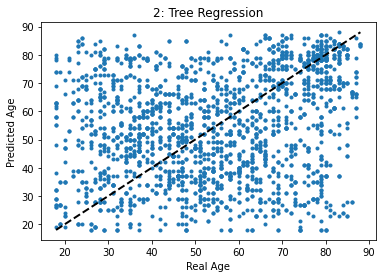

In [36]:
# Single Features

results_0 = repeated_k_fold(X[:, [0]], y, models, 2, 5)
results_1 = repeated_k_fold(X[:, [1]], y, models, 2, 5)
results_2 = repeated_k_fold(X[:, [2]], y, models, 2, 5)

for r in results_0:
  evaluate_results(r[0], r[1], "0: " + r[2])

for r in results_1:
  evaluate_results(r[0], r[1], "1: " + r[2])

for r in results_2:
  evaluate_results(r[0], r[1], "2: " + r[2])

01: Ridge Regression
MAE: 11.061831573348131
R2: 0.5031656222980818
MVS: 0.5031656641279674
MSE: 169.11021793007907


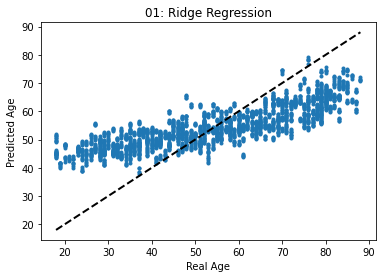

01: Linear Regression
MAE: 8.199825781569446
R2: 0.6915625555557734
MVS: 0.6915640792041425
MSE: 104.9845296314294


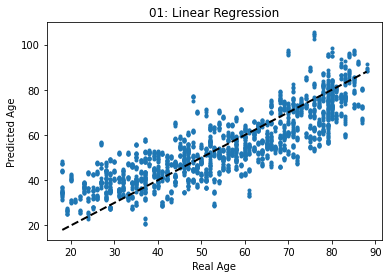

01: Support Vector Regression
MAE: 8.223681426675302
R2: 0.6986833523478195
MVS: 0.6993453905782189
MSE: 102.56078531866928


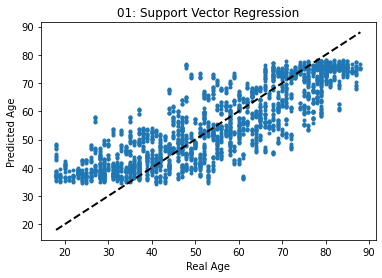

01: Tree Regression
MAE: 10.7972
R2: 0.44717162257266996
MVS: 0.44792621944669353
MSE: 188.1692


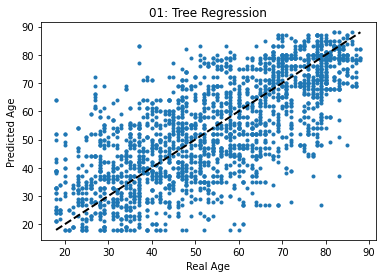

12: Ridge Regression
MAE: 12.939081615997347
R2: 0.33270066612324867
MVS: 0.33270100168803696
MSE: 227.13230171080883


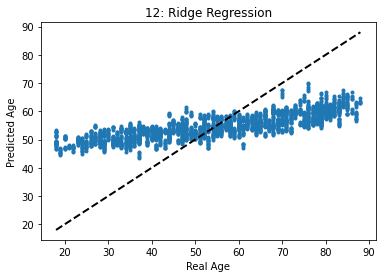

12: Linear Regression
MAE: 8.217087314838256
R2: 0.6900586168562144
MVS: 0.6900586185051578
MSE: 105.49643342200906


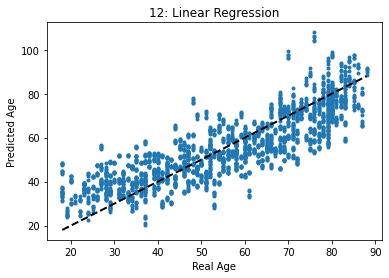

12: Support Vector Regression
MAE: 8.829545121141447
R2: 0.662953880512672
MVS: 0.6635983552394981
MSE: 114.72221987260738


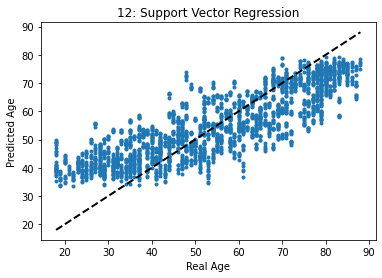

12: Tree Regression
MAE: 10.6492
R2: 0.441772878110981
MVS: 0.44180689278647023
MSE: 190.0068


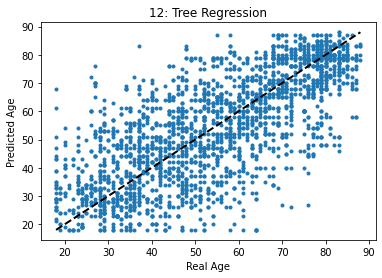

02: Ridge Regression
MAE: 12.230798784331972
R2: 0.39791807712274185
MVS: 0.3979181146874632
MSE: 204.93389700706513


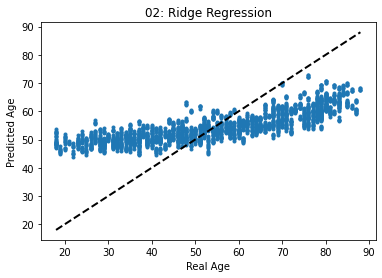

02: Linear Regression
MAE: 8.211841157439633
R2: 0.6899857531690587
MVS: 0.6899859343983386
MSE: 105.52123443129324


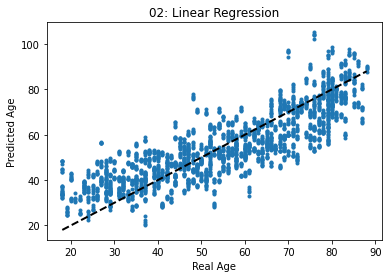

02: Support Vector Regression
MAE: 8.32531291398942
R2: 0.6869273128941078
MVS: 0.6895448342508358
MSE: 106.56225237335963


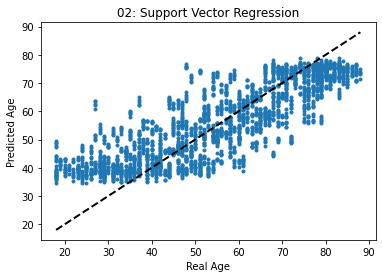

02: Tree Regression
MAE: 10.4992
R2: 0.45752372095382354
MVS: 0.4576547687183866
MSE: 184.6456


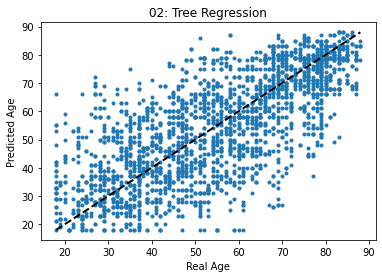

In [37]:
# Double Features

results_0_1 = repeated_k_fold(X[:, [0,1]], y, models, 2, 5)
results_1_2 = repeated_k_fold(X[:, [1,2]], y, models, 2, 5)
results_0_2 = repeated_k_fold(X[:, [0,2]], y, models, 2, 5)

for r in results_0_1:
  evaluate_results(r[0], r[1], "01: " + r[2])

for r in results_1_2:
  evaluate_results(r[0], r[1], "12: " + r[2])

for r in results_0_2:
  evaluate_results(r[0], r[1], "02: " + r[2])

Comb01: Ridge Regression
MAE: 15.686036342300667
R2: 0.019796265661922496
MVS: 0.01979626607311935
MSE: 333.63727344415133


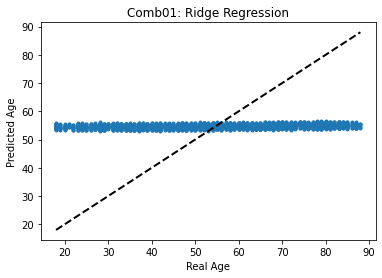

Comb01: Linear Regression
MAE: 9.354926931355498
R2: 0.5914837929692005
MVS: 0.5914840091691953
MSE: 139.04888208117467


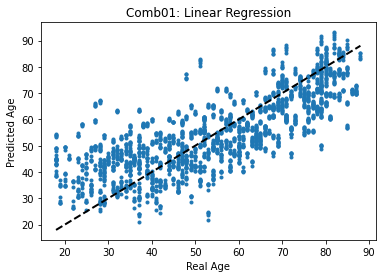

Comb01: Support Vector Regression
MAE: 9.558768201778992
R2: 0.5730576476337781
MVS: 0.5811747335503805
MSE: 145.3206893335184


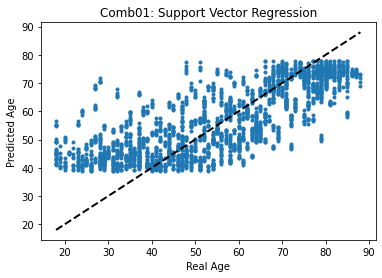

Comb01: Tree Regression
MAE: 12.4324
R2: 0.23994397762592956
MVS: 0.24012292778965405
MSE: 258.7044


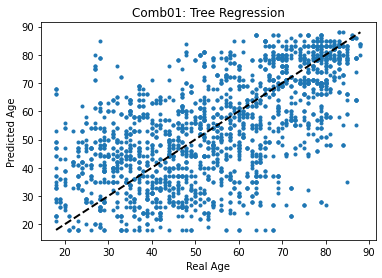

Comb12: Ridge Regression
MAE: 15.686036342300667
R2: 0.019796265661922496
MVS: 0.01979626607311935
MSE: 333.63727344415133


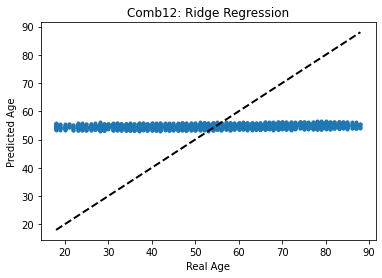

Comb12: Linear Regression
MAE: 9.354926931355498
R2: 0.5914837929692005
MVS: 0.5914840091691953
MSE: 139.04888208117467


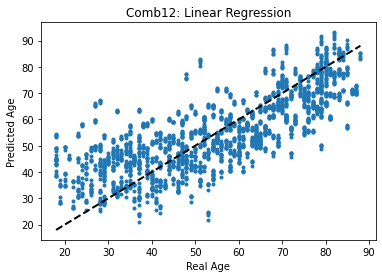

Comb12: Support Vector Regression
MAE: 9.558768201778992
R2: 0.5730576476337781
MVS: 0.5811747335503805
MSE: 145.3206893335184


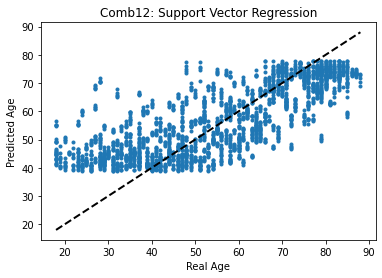

Comb12: Tree Regression
MAE: 12.4324
R2: 0.23994397762592956
MVS: 0.24012292778965405
MSE: 258.7044


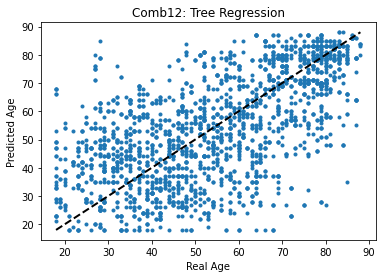

Comb02: Ridge Regression
MAE: 15.686036342300667
R2: 0.019796265661922496
MVS: 0.01979626607311935
MSE: 333.63727344415133


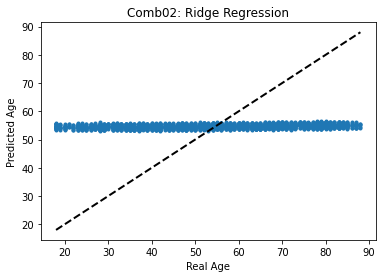

Comb02: Linear Regression
MAE: 9.354926931355498
R2: 0.5914837929692005
MVS: 0.5914840091691953
MSE: 139.04888208117467


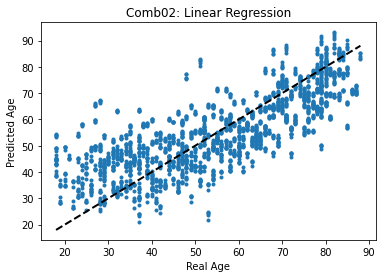

Comb02: Support Vector Regression
MAE: 9.558768201778992
R2: 0.5730576476337781
MVS: 0.5811747335503805
MSE: 145.3206893335184


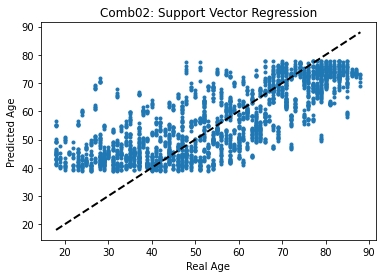

Comb02: Tree Regression
MAE: 12.4324
R2: 0.23994397762592956
MVS: 0.24012292778965405
MSE: 258.7044


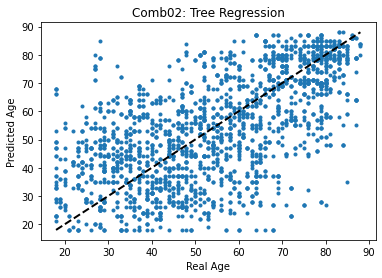

In [38]:
# Combinations

x_comb_0_1 = (X[:, 0] * X[:, 1]).reshape(-1,1)
#x_comb_0_1 = ((x_comb_0_1 - x_comb_0_1.mean(axis=0)) / x_comb_0_1.std(axis=0)) 
results_comb_0_1 = repeated_k_fold(x_comb_0_1, y, models, 2, 5)

x_comb_1_2 = (X[:, 1] * X[:, 2]).reshape(-1,1)
#x_comb_1_2 = ((x_comb_1_2 - x_comb_1_2.mean(axis=0)) / x_comb_1_2.std(axis=0))
results_comb_1_2 = repeated_k_fold(x_comb_1_2, y, models, 2, 5)

x_comb_0_2 = (X[:, 0] * X[:, 2]).reshape(-1,1)
#x_comb_0_2 = ((x_comb_0_2 - x_comb_0_2.mean(axis=0)) / x_comb_0_2.std(axis=0))
results_comb_0_2 = repeated_k_fold(x_comb_0_2, y, models, 2, 5)

for r in results_comb_0_1:
  evaluate_results(r[0], r[1], "Comb01: " + r[2])

for r in results_comb_0_1:
  evaluate_results(r[0], r[1], "Comb12: " + r[2])

for r in results_comb_0_1:
  evaluate_results(r[0], r[1], "Comb02: " + r[2])

123: Linear Regression
MAE: 8.213675
R2: 0.6899187679033557
MVS: 0.6899249239017133
MSE: 105.5440345703125


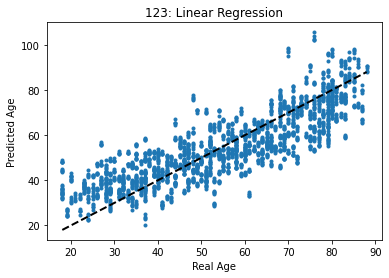

123: Support Vector Regression
MAE: 8.264888812228866
R2: 0.6943914906152857
MVS: 0.6956861996213146
MSE: 104.02162962713223


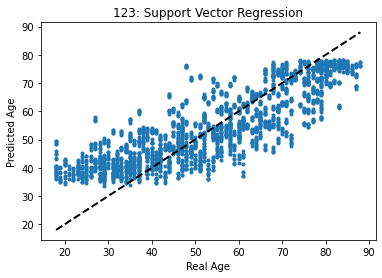

12: Linear Regression
MAE: 8.193588003664578
R2: 0.6914388220132555
MVS: 0.6914400451281054
MSE: 105.0266454899118


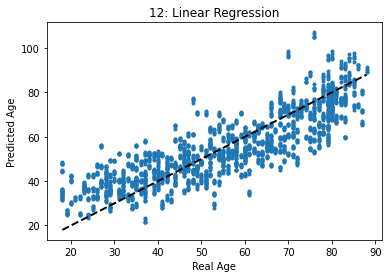

12: Support Vector Regression
MAE: 8.77115904768465
R2: 0.6669509005154046
MVS: 0.6677028208849339
MSE: 113.36173244647654


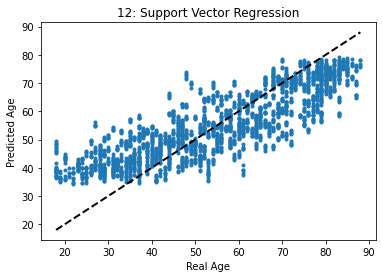

best: Linear Regression
MAE: 7.946965743348429
R2: 0.7032573566578213
MVS: 0.7032573695399521
MSE: 101.00390660738661


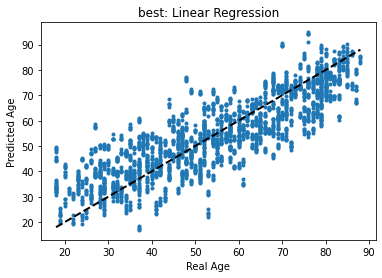

best: Support Vector Regression
MAE: 8.984944717274148
R2: 0.6371706720511103
MVS: 0.6453486794089012
MSE: 123.49819069419033


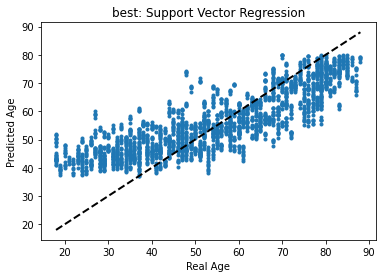

Log 123: Linear Regression
MAE: 9.195319807979907
R2: 0.5896420530612065
MVS: 0.591786510350073
MSE: 139.6757651053567


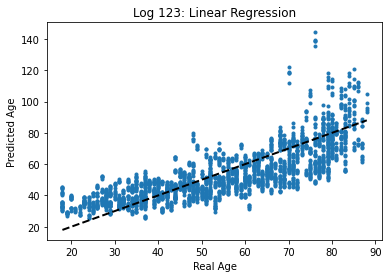

Log 123: Support Vector Regression
MAE: 7.684012033632625
R2: 0.7174246720362002
MVS: 0.7176181335910847
MSE: 96.18170045852135


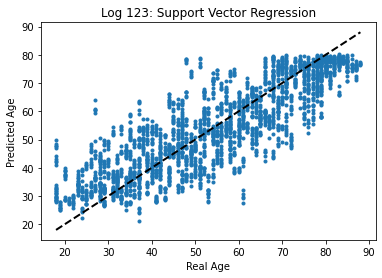

Log 12: Linear Regression
MAE: 9.16942466623908
R2: 0.5955120954749933
MVS: 0.5980973892715383
MSE: 137.67774685942553


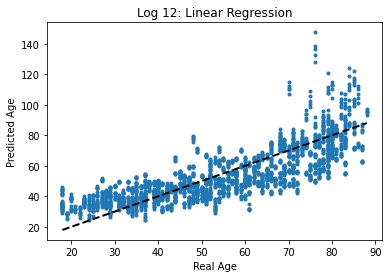

Log 12: Support Vector Regression
MAE: 7.804894583027347
R2: 0.7108841644863896
MVS: 0.7109396050234156
MSE: 98.40792856744943


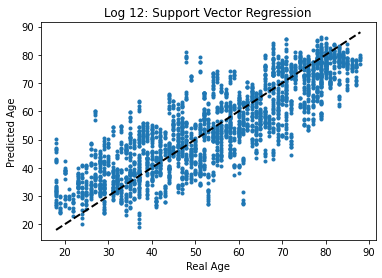

Log best: Linear Regression
MAE: 7.90317452383267
R2: 0.7070459888760487
MVS: 0.7101450294974707
MSE: 99.71434926426377


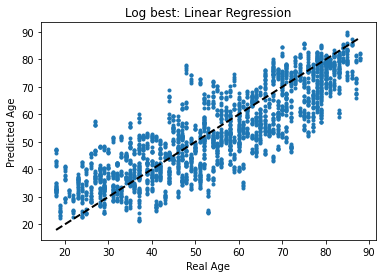

Log best: Support Vector Regression
MAE: 7.807581529983085
R2: 0.7140494970341589
MVS: 0.7143644117068022
MSE: 97.33052712141748


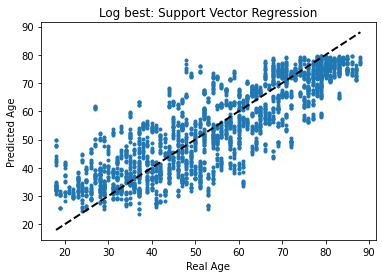

In [39]:
# Narrowing down
final_models = {("Linear Regression", LinearRegression),
                ("Support Vector Regression", SVR)}

results_1_2_3 = repeated_k_fold(X, y, final_models, 2, 5)
for r in results_1_2_3:
  evaluate_results(r[0], r[1], "123: " + r[2])

results_1_2 = repeated_k_fold(X[:, [1,2]], y, final_models, 2, 5)
for r in results_1_2:
  evaluate_results(r[0], r[1], "12: " + r[2])

#best_X = np.concatenate(((X[:, 1] ** 2).reshape(-1, 1), (X[:,0] * X[:,2]).reshape(-1, 1)), axis=1)
best_X = np.concatenate((((X[:, 1] ** 2) * X[:,2]).reshape(-1, 1), (X[:,0]).reshape(-1, 1)), axis=1)
best_combo = repeated_k_fold(best_X, y, final_models, 2, 5)
for r in best_combo:
  evaluate_results(r[0], r[1], "best: " + r[2])

####################################################################

log_results = repeated_k_fold(X, log_y, final_models, 2, 5)
for r in log_results:
  evaluate_results(np.exp(r[0]) - 1, np.exp(r[1]) - 1, "Log 123: " + r[2])

log_results = repeated_k_fold(X[:, [1,2]], log_y, final_models, 2, 5)
for r in log_results:
  evaluate_results(np.exp(r[0]) - 1, np.exp(r[1]) - 1, "Log 12: " + r[2])

#best_X =  np.concatenate(((X[:, 1] ** 2).reshape(-1, 1), (X[:,0] * X[:,2]).reshape(-1, 1)), axis=1)
best_X = np.concatenate((((X[:, 1] ** 2) * X[:,2]).reshape(-1, 1), (X[:,0] ** 3).reshape(-1, 1)), axis=1)
best_combo = repeated_k_fold(best_X, log_y, final_models, 2, 5)
for r in best_combo:
  evaluate_results(np.exp(r[0]) - 1, np.exp(r[1]) - 1, "Log best: " + r[2])

In [40]:
# Final Best Model

  

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [41]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-02-28 09:07:49--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-02-28 09:07:50 (289 MB/s) - ‘brainage-testdata.zip’ saved [1521/1521]

Archive:  brainage-testdata.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [42]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


In [43]:
# And training data
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_train = list(meta_data_reg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]#[:5]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]#[:5]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]#[:5]

dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:24<00:00,  5.92it/s]


#### Run final testing

In [44]:
def load_and_segment(model, dataset, dataloader, path_to_save):
  pred_dir = os.path.join(out_dir, path_to_save)#'pred')
  if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
    
  print('START TESTING...' + path_to_save)
  loss_test = 0
  sum_pts = 0
  idx_test = 0
  dsc = 0
  with torch.no_grad():
    for data_sample in dataloader:
      img, seg, msk = data_sample['img'].to(device), data_sample['seg'].to(device), data_sample['msk'].to(device)
      prd = model(img)
      loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
      sum_pts += np.prod(img_size)      
      prd = torch.argmax(prd, dim=1)
      # TODO: add additional metrics #
      # Add dice score
      dsc += dice_score(prd.cpu() * msk.cpu(), seg.cpu() * msk.cpu(), 0)
      # Add Surface distance?
      ################################

      sample = dataset.get_sample(idx_test)
      name = dataset.get_seg_name(idx_test)
      prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
      prediction.CopyInformation(sample['seg'])
      sitk.WriteImage(prediction, os.path.join(pred_dir, name))
      
      idx_test += 1
        
  loss_test /= sum_pts
  dsc /= len(dataloader)
  print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
  print("+         \tDSC: " + str(dsc))

  # Show last testing sample as an example
  print('\n\nReference segmentation')
  display_image(sitk.LabelToRGB(sample['seg']))
  print('Predicted segmentation')
  display_image(sitk.LabelToRGB(prediction))

  print('\nFinished TESTING.')

In [45]:
def preprocess_for_regression(dir, meta_data):
  # USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
  seg_dir = './output/' + dir + '/' 

  meta_data_reg_train = pd.read_csv(data_dir + 'meta/' + meta_data + '.csv')
  ids_reg_train = list(meta_data_reg_train['subject_id'])
  files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

  # THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
  vols = np.zeros((3,len(files_reg_seg_train)))

  for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    seg_filename = files_reg_seg_train[idx]
    if os.path.exists(seg_filename):
      seg = sitk.ReadImage(seg_filename)
      seg_img = sitk.GetArrayFromImage(seg)
      vols[0][idx] = np.sum(seg_img == 1)
      vols[1][idx] = np.sum(seg_img == 2)
      vols[2][idx] = np.sum(seg_img == 3)
  
  vols_normalised = np.zeros((3,len(files_reg_seg_train)))
  vols_normalised = vols / vols.sum(axis=0)

  X = vols_normalised.T
  y = meta_data_reg_train['age'].values.reshape(-1,1)

  # Modify for best results
  #X = np.concatenate((((X[:, 1] ** 2) * X[:,2]).reshape(-1, 1), (X[:,0]).reshape(-1, 1)), axis=1)
  X = np.concatenate((((X[:, 1] ** 2) * X[:,2]).reshape(-1, 1), (X[:,0] ** 3).reshape(-1, 1)), axis=1)

  return X, y

In [46]:
import sklearn
import numpy as np
from sklearn.svm import SVR

def apply_log(y):
  return np.log(y+1)

def remove_log(log_y):
  return np.exp(log_y) - 1 

def train_best_regressor_model(X, y):
  # Apply logs to predictions
  
  model = SVR()
  model.fit(X, y)

  return model


START TESTING...pred_500
+ TESTING 	Loss: 0.083005
+         	DSC: 0.9014500387067896


Reference segmentation


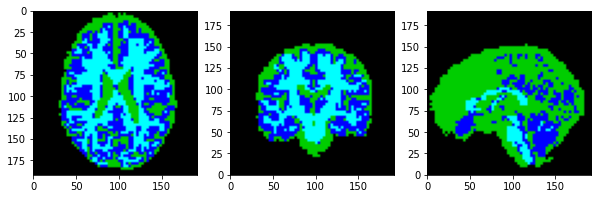

Predicted segmentation


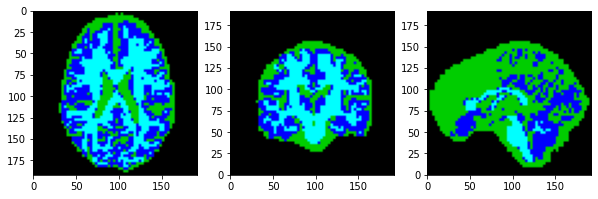

Calculating Features:   9%|▉         | 46/500 [00:00<00:01, 453.36it/s]


Finished TESTING.


Calculating Features: 100%|██████████| 500/500 [00:01<00:00, 450.52it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


START TESTING...test
+ TESTING 	Loss: 0.078814
+         	DSC: 0.9001423511272786


Reference segmentation


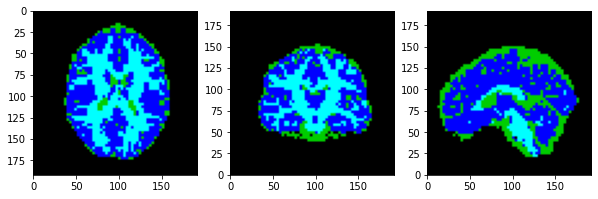

Predicted segmentation


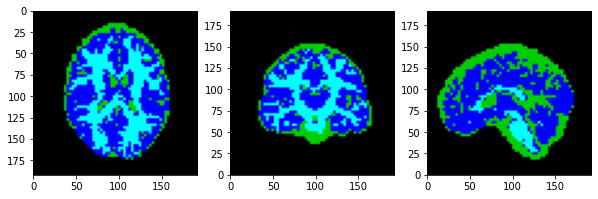

Calculating Features:  44%|████▍     | 44/100 [00:00<00:00, 435.33it/s]


Finished TESTING.


Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 440.09it/s]


Final best
MAE: 7.658496613445356
R2: 0.7698353725871167
MVS: 0.7717498262527548
MSE: 87.03765149822871


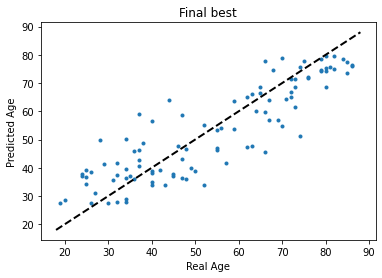

In [47]:
########################################
# ADD YOUR CODE HERE
######################################## 
# Load trained unet
model = UNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
# Segment the 500 train data
load_and_segment(model, dataset_train, dataloader_train, "pred_500")
# Preprocess segmentations for regression
X, y = preprocess_for_regression("pred_500", "meta_data_regression_train")
# Train our best regression model using all 500 sample data
regressor = train_best_regressor_model(X, apply_log(y))
# Segment the test data
load_and_segment(model, dataset_test, dataloader_test, "test")
# Preprocess segmentations for regression
X_test, y_test = preprocess_for_regression("test", "meta_data_regression_test")
# Fit test segmentation with regression model
predicted = remove_log(regressor.predict(X_test))
# Evaluate scores
evaluate_results(y_test, predicted, "Final best")

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [48]:
########################################
# ADD YOUR CODE HERE
########################################

**Modified data-helper**

In [49]:
class ImageRegressionDataset(Dataset):
    """Dataset helper for image regression."""

    def __init__(self, file_list_img, file_list_age, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            # note: mask still needed for the normalisation
            msk_path = file_list_msk[idx] 
            
            age = np.array([file_list_age[idx]]) 
            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre-processing
            # normalising:
            img = zero_mean_unit_var(img, msk) 
            # resampling:
            img = resample_image(img, img_spacing, img_size, is_label=False)

            sample = {'img': img, 'age': age} # age is now included as well

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img']))
        age = torch.from_numpy(sample['age'])
        return {'img': image, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


**Regression Hyperparameters**

In [158]:
rnd_seed = 42 #fixed random seed

# for resampling:
img_size = [64, 64, 64] 
img_spacing = [3, 3, 3] 

num_epochs = 50 # 30
learning_rate = 0.001# 0.001 
batch_size = 64
batch_size_valid = 2 # 1
val_interval = 10

**Loading adn pre-processing of regression data**

In [98]:
# Training Data
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])


files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_reg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]
files_reg_age_train = list(meta_data_reg_train['age'])
# load train
dataset_train = ImageRegressionDataset(files_reg_img_train, files_reg_age_train, files_reg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

# Validation Data
meta_data_reg_valid = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_reg_valid = list(meta_data_reg_valid['subject_id'])

files_reg_img_valid = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_valid]
files_reg_msk_valid = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_valid]
files_reg_age_valid = list(meta_data_reg_valid['age'])
# load valid
dataset_valid = ImageRegressionDataset(files_reg_img_valid, files_reg_age_valid, files_reg_msk_valid, img_spacing, img_size)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_valid, shuffle=False)

# Test Data - this to change

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])

files_reg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_test]
files_reg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_test]
files_reg_age_test = list(meta_data_reg_test['age'])

dataset_test = ImageRegressionDataset(files_reg_img_test, files_reg_age_test, files_reg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_valid, shuffle=False)


Loading Data: 100%|██████████| 500/500 [01:21<00:00,  6.10it/s]

Loading Data: 100%|██████████| 47/47 [00:07<00:00,  6.03it/s]

Loading Data: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


**Visualise Example**

sample age:[74]
Image: sub-CC620592_T1w_unbiased.nii.gz


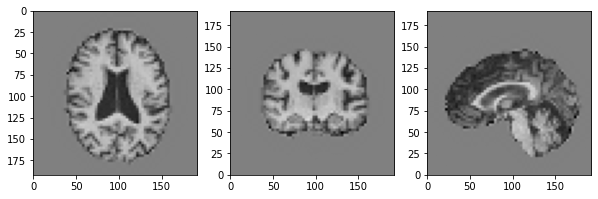

In [99]:
sample = dataset_train.get_sample(2)
print("sample age:" + str(sample["age"]))
img_name = dataset_train.get_img_name(2)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)

# **Defining CNN Architectures**

**Vanilla CNN (AlexNet Inspired)**

In [100]:
class Vanilla_CNN(nn.Module):

    def __init__(self):
        super(Vanilla_CNN, self).__init__()

        self.features = nn.Sequential(
            
            nn.Conv2d(64, 192, kernel_size=3),
            nn.BatchNorm2d(192),
            nn.ReLU(True),

            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(True),

            nn.Conv2d(384, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.MaxPool2d(kernel_size=3, stride=2), 
        )

        self.regressor = nn.Sequential(
            
            nn.Linear(2304, 4096), # change this depending on the input dim
            nn.ReLU(True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(True),

            nn.Linear(4096, 1)
        )

    def forward(self, x):
      # note: assuming input of dim [batch_size, 64, 64, 64]
      
        x = self.features(x) # [batch_size, 256, 3, 3]
        x = x.view(x.size(0), -1) # [batch_size, 2304]
        output = self.regressor(x) # [batch_size, 1]
        
        return output

**Deep CNN (VGG Inspired)**

In [101]:
class Deep_CNN(torch.nn.Module):

    def __init__(self):
        super(Deep_CNN, self).__init__()

        self.features_1 = nn.Sequential(
            
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, 
                          stride=1, padding=1),
                nn.BatchNorm2d(128),     
                nn.ReLU(),

                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,
                          stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),

                nn.MaxPool2d(kernel_size=2, stride=2) 
                ) 
        
        self.features_2 = nn.Sequential(        
                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,
                          stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),

                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,
                          stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),        

                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,
                          stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),

                nn.MaxPool2d(kernel_size=2, stride=2)
                ) 
         
        self.features_3 = nn.Sequential(   
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,
                          stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),        

                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,
                          stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),        

                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,
                          stride=2, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=2, stride=2)
                ) 
        
        self.features_4 = nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,
                          stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),            

                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,
                          stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),         

                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,
                          stride=2, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),    

                nn.MaxPool2d(kernel_size=2, stride=2)             
                ) 
            
        self.regressor = nn.Sequential(
            
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(True),

            nn.Linear(4096, 1),
            )
        
    def forward(self, x):
      # note: assuming input of dim [batch_size, 64, 64, 64]

        x = self.features_1(x) # [batch_size, 128, 32, 32]
        x = self.features_2(x) # [batch_size, 256, 16, 16]
        x = self.features_3(x) # [batch_size, 512, 4, 4]
        x = self.features_4(x) # [batch_size, 512, 1, 1]
        x = x.view(x.size(0), -1) # [batch_size, 512]
        output = self.regressor(x) # [batch_size, 1]

        return output

**REsNet**

In [159]:
# Note: Following ResNet implementation is based on the implementation 
# presented in the Deep Learning Module's Coursework 1

# define ResNet building blocks:

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride): 
        
        super(ResidualBlock, self).__init__() 
        
        self.block = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                         nn.BatchNorm2d(outchannel), 
                                         nn.ReLU(inplace=True), 
                                  
                                  nn.Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                         nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        # takes care of case where input to self.block is different dims than output
        # so that the original input (transformed) can be added again 
        # (i.e. skip connection), note the 1x1 kernel. 
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(nn.Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                                 nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        # x inputted into block
        out = self.block(x) 
        # original x added with shortcut applied if neccessary to out
        out += self.shortcut(x) 
        out = F.relu(out) 
        return out

# Using above defined residual blocks to define ResNet:
class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 1):
        super(ResNet, self).__init__()

        self.inchannel = 64 # assuming inchannel is 64

        self.conv1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                            nn.BatchNorm2d(64), 
                                            nn.ReLU()) 
        
        self.layer1 = self.make_layer(ResidualBlock, channels = 64, 
                                      num_blocks = 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, channels = 128, 
                                      num_blocks = 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, channels = 256, 
                                      num_blocks = 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, channels = 512, 
                                      num_blocks = 2, stride = 2)
        self.maxpool = nn.MaxPool2d(4)
        self.fc = nn.Linear(512, 1)
        
    # function to create residual layer:
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels # update inchannel
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
      # note assuming an input of dim [batch_size, 64,64,64]
        
        x = self.conv1(x) # [batch_size, 64, 62, 62]
        x = self.layer1(x) # [batch_size, 64, 31, 31]
        x = self.layer2(x) # [batch_size, 128, 16, 16]
        x = self.layer3(x) # [batch_size, 256, 8, 8]
        x = self.layer4(x) # [batch_size, 512, 4, 4]
        x = self.maxpool(x) # [batch_size, 512, 1, 1]
        x = x.view(x.size(0), -1) # [batch_size, 512]
        x = self.fc(x) # [batch_size, 1]
        
        return x

In [160]:
# Using above defined residual blocks to define ResNet:
class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 1):
        super(ResNet, self).__init__()

        self.inchannel = 64 # assuming inchannel is 64

        self.conv1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                            nn.BatchNorm2d(64), 
                                            nn.ReLU()) 
        
        self.layer1 = self.make_layer(ResidualBlock, channels = 64, 
                                      num_blocks = 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, channels = 128, 
                                      num_blocks = 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, channels = 256, 
                                      num_blocks = 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, channels = 512, 
                                      num_blocks = 2, stride = 2)
        self.maxpool = nn.MaxPool2d(4)
        self.fc = nn.Linear(512, 1)
        self.dropout = nn.Dropout3d(0.5)
        
    # function to create residual layer:
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels # update inchannel
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
      # note assuming an input of dim [batch_size, 64,64,64]
        
        x = self.conv1(x) # [batch_size, 64, 62, 62]
        x = self.layer1(x) # [batch_size, 64, 31, 31]
        x = self.layer2(x) # [batch_size, 128, 16, 16]
        x = self.layer3(x) # [batch_size, 256, 8, 8]
        x = self.layer4(x) # [batch_size, 512, 4, 4]
        x = self.dropout(x)
        x = self.maxpool(x) # [batch_size, 512, 1, 1]
        x = x.view(x.size(0), -1) # [batch_size, 512]
        x = self.fc(x) # [batch_size, 1]
        
        return x

**Two-Fold Cross Validation**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


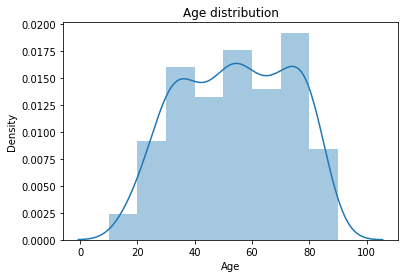


Loading Data: 100%|██████████| 250/250 [00:40<00:00,  6.11it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


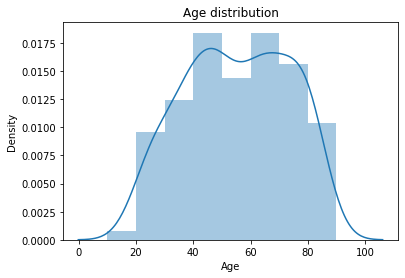


Loading Data: 100%|██████████| 250/250 [00:41<00:00,  6.02it/s]


In [133]:
import random
from sklearn.model_selection import KFold
# Training Data
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
random.Random(4).shuffle(ids_seg_test) # shuffling data

# Fold 1:
files_reg_img_train_1 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test][:250]
files_reg_msk_train_1 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test][:250]
files_reg_age_train_1 = list(meta_data_reg_train['age'])[:250]

sns.distplot(files_reg_age_train_1, bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

# load fold 1
dataset_cross_1 = ImageRegressionDataset(files_reg_img_train_1, files_reg_age_train_1, files_reg_msk_train_1, img_spacing, img_size)
dataloader_cross_1 = torch.utils.data.DataLoader(dataset_cross_1, batch_size=batch_size, shuffle=False)


# Fold 2:
files_reg_img_train_2 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test][250:]
files_reg_msk_train_2 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test][250:]
files_reg_age_train_2 = list(meta_data_reg_train['age'])[250:]

sns.distplot(files_reg_age_train_2, bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

# load fold 2
dataset_cross_2 = ImageRegressionDataset(files_reg_img_train_2, files_reg_age_train_2, files_reg_msk_train_2, img_spacing, img_size)
dataloader_cross_2 = torch.utils.data.DataLoader(dataset_cross_2, batch_size=batch_size, shuffle=False)

START TRAINING...
--------------------------------------------------
Cross Validation: 1st fold
--------------------------------------------------
+ TRAINING 	Epoch: 1 	Loss: 690.5496 	MAE across Epoch: 37.9923
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 12984.6238 	MAE: 53.9902
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 291.2815 	MAE across Epoch: 15.0059
+ TRAINING 	Epoch: 3 	Loss: 112.3905 	MAE across Epoch: 10.4953
+ TRAINING 	Epoch: 4 	Loss: 100.4480 	MAE across Epoch: 7.6695
+ TRAINING 	Epoch: 5 	Loss: 62.0624 	MAE across Epoch: 8.2068
+ TRAINING 	Epoch: 6 	Loss: 62.0233 	MAE across Epoch: 7.2128
+ TRAINING 	Epoch: 7 	Loss: 34.9587 	MAE across Epoch: 5.2487
+ TRAINING 	Epoch: 8 	Loss: 57.6536 	MAE across Epoch: 5.5154
+ TRAINING 	Epoch: 9 	Loss: 36.0057 	MAE across Epoch: 5.1746
+ TRAINING 	Epoch: 10 	Loss: 58.7196 	MAE across Epoch: 5.2140
--------------------------------------------------
+ VALIDATE 	Epoch: 

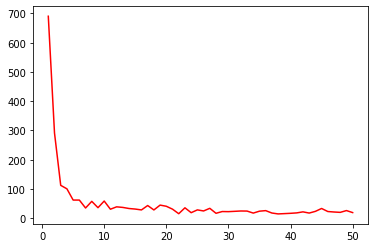

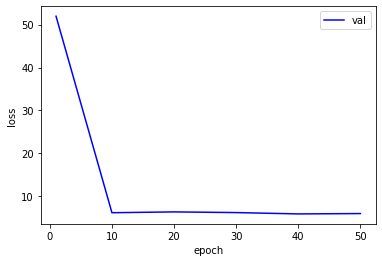

START TRAINING...
--------------------------------------------------
Cross Validation: 2nd fold
--------------------------------------------------
+ TRAINING 	Epoch: 1 	Loss: 442.8834 	MAE across Epoch: 35.1933
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 12914.0298 	MAE: 53.6668
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 276.6374 	MAE across Epoch: 15.6899
+ TRAINING 	Epoch: 3 	Loss: 135.7435 	MAE across Epoch: 10.4138
+ TRAINING 	Epoch: 4 	Loss: 51.1394 	MAE across Epoch: 6.7842
+ TRAINING 	Epoch: 5 	Loss: 54.5383 	MAE across Epoch: 7.2237
+ TRAINING 	Epoch: 6 	Loss: 60.3212 	MAE across Epoch: 6.9404
+ TRAINING 	Epoch: 7 	Loss: 55.9018 	MAE across Epoch: 6.3526
+ TRAINING 	Epoch: 8 	Loss: 47.1457 	MAE across Epoch: 6.2117
+ TRAINING 	Epoch: 9 	Loss: 33.6463 	MAE across Epoch: 4.8972
+ TRAINING 	Epoch: 10 	Loss: 38.7625 	MAE across Epoch: 5.0522
--------------------------------------------------
+ VALIDATE 	Epoch: 1

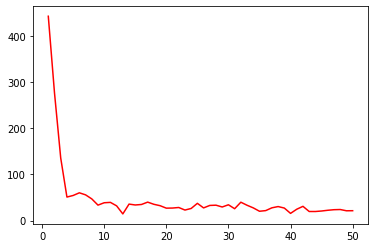

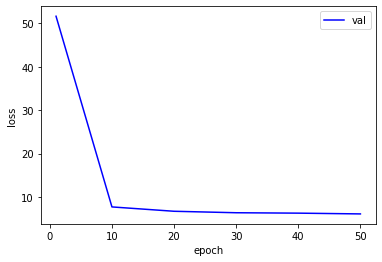

In [161]:
dtype = torch.float32 

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

rnd_seed = 1
torch.manual_seed(rnd_seed) #fix random seed
torch.cuda.manual_seed(rnd_seed)
torch.backends.cudnn.deterministic = True

#model = Vanilla_CNN().to(device)
#model = Deep_CNN().to(device)
model = ResNet(ResidualBlock).to(device)
#model = ResNet2(ResidualBlock).to(device)
   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

##################################################################
# Here, initially, use first fold as training, then validate on second fold
# Then do vice versa, i.e. use first second as training, then validate on first fold

    
print('START TRAINING...')
print('--------------------------------------------------')
print("Cross Validation: 1st fold")
print('--------------------------------------------------')

# for plotting purposes:
loss_train_log = [] # keep track of train loss
loss_val_log = [] # keep track of validation loss
epoch_val_log = [] # keep track of epoch


for epoch in range(1, num_epochs + 1):

    train_total_epoch_abserr = 0 # will be used to calculate cumulative epoch absolute error
    train_no_observations = 0 # will be used to average sse

    # Training
    model.train()
    for batch_idx, batch_samples in enumerate(dataloader_cross_1):
        img, age = batch_samples['img'].to(device, dtype=dtype), batch_samples['age'].to(device, dtype=dtype)
        train_no_observations += img.size(0) # add current batch size 
        optimizer.zero_grad()
        prd = model(img)
        loss = F.mse_loss(prd, age) # MSE loss since regression
        loss.backward()
        optimizer.step()

        with torch.no_grad(): # calculating sse
          train_total_epoch_abserr += np.sum(np.abs(prd.detach().cpu().numpy() 
                                              - age.detach().cpu().numpy())) # abs error

    loss_train_log.append(loss.item())
    print(f'+ TRAINING \tEpoch: {epoch} \tLoss: {loss.item():.4f} \tMAE across Epoch: {(train_total_epoch_abserr/train_no_observations):.4f}')
    
    # Validation
    # validatin stats calculated every 10 epochs
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        valid_no_obs = 0
        total_abserr=0
        
        model.eval()
        with torch.no_grad():
            for data_sample in dataloader_cross_2:
                img, age = data_sample['img'].to(device, dtype=dtype), data_sample['age'].to(device, dtype=dtype)
                valid_no_obs += img.size(0) # add current batch size
                prd = model(img)
                loss_val += F.mse_loss(prd, age).item()
                total_abserr += np.sum(np.abs(prd.detach().cpu().numpy() 
                                   - age.detach().cpu().numpy())) # abs error
                
        loss_val_log.append(loss_val/valid_no_obs) # change this 
        epoch_val_log.append(epoch)
        

        print('--------------------------------------------------')
        print(f'+ VALIDATE \tEpoch: {epoch} \tLoss: {loss_val:.4f} \tMAE: {(total_abserr/valid_no_obs):.4f}')
        print('--------------------------------------------------')

plot1 = plt.figure(1)
plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')

plot2 = plt.figure(2)
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


print('START TRAINING...')
print('--------------------------------------------------')
print("Cross Validation: 2nd fold")
print('--------------------------------------------------')

# for plotting purposes:
loss_train_log = [] # keep track of train loss
loss_val_log = [] # keep track of validation loss
epoch_val_log = [] # keep track of epoch

model = ResNet(ResidualBlock).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)


for epoch in range(1, num_epochs + 1):

    train_total_epoch_abserr = 0 # will be used to calculate cumulative epoch absolute error
    train_no_observations = 0 # will be used to average sse

    # Training
    model.train()
    for batch_idx, batch_samples in enumerate(dataloader_cross_2):
        img, age = batch_samples['img'].to(device, dtype=dtype), batch_samples['age'].to(device, dtype=dtype)
        train_no_observations += img.size(0) # add current batch size 
        optimizer.zero_grad()
        prd = model(img)
        loss = F.mse_loss(prd, age) # MSE loss since regression
        loss.backward()
        optimizer.step()

        with torch.no_grad(): # calculating sse
          train_total_epoch_abserr += np.sum(np.abs(prd.detach().cpu().numpy() 
                                              - age.detach().cpu().numpy())) # abs error

    loss_train_log.append(loss.item())

    print(f'+ TRAINING \tEpoch: {epoch} \tLoss: {loss.item():.4f} \tMAE across Epoch: {(train_total_epoch_abserr/train_no_observations):.4f}')
    
    # Validation
    # validatin stats calculated every 10 epochs
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        valid_no_obs = 0
        total_abserr =0
        
        model.eval()
        with torch.no_grad():
            for data_sample in dataloader_cross_1:
                img, age = data_sample['img'].to(device, dtype=dtype), data_sample['age'].to(device, dtype=dtype)
                valid_no_obs += img.size(0) # add current batch size
                prd = model(img)
                loss_val += F.mse_loss(prd, age).item()
                total_abserr += np.sum(np.abs(prd.detach().cpu().numpy() 
                                   - age.detach().cpu().numpy())) # abs error
                
        loss_val_log.append(loss_val/valid_no_obs) # change this 
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print(f'+ VALIDATE \tEpoch: {epoch} \tLoss: {loss_val:.4f} \tMAE: {(total_abserr/valid_no_obs):.4f}')
        print('--------------------------------------------------')

    
print('\nFinished TRAINING.')

plot1 = plt.figure(1)
plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')

plot2 = plt.figure(2)
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


**Final Training (on full 500 samples, using 47 subjects as validation)**

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 125.3750 	MAE across Epoch: 24.5844
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 56007.0624 	MAE: 44.8991
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 91.6952 	MAE across Epoch: 9.5305
+ TRAINING 	Epoch: 3 	Loss: 105.5367 	MAE across Epoch: 8.4746
+ TRAINING 	Epoch: 4 	Loss: 99.4045 	MAE across Epoch: 7.4516
+ TRAINING 	Epoch: 5 	Loss: 65.5688 	MAE across Epoch: 6.9534
+ TRAINING 	Epoch: 6 	Loss: 31.4460 	MAE across Epoch: 5.8512
+ TRAINING 	Epoch: 7 	Loss: 37.7479 	MAE across Epoch: 5.3534
+ TRAINING 	Epoch: 8 	Loss: 34.1816 	MAE across Epoch: 4.8058
+ TRAINING 	Epoch: 9 	Loss: 45.2259 	MAE across Epoch: 4.9434
+ TRAINING 	Epoch: 10 	Loss: 37.7236 	MAE across Epoch: 4.6195
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 2939.1523 	MAE: 8.5327
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 36.9754 	MAE across 

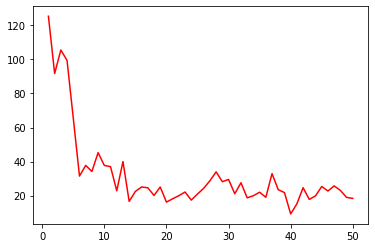

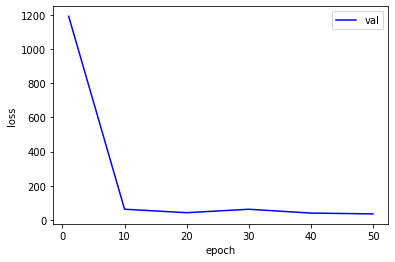

In [162]:
dtype = torch.float32 

rnd_seed = 1
torch.manual_seed(rnd_seed) #fix random seed
torch.cuda.manual_seed(rnd_seed)
torch.backends.cudnn.deterministic = True

#model = Vanilla_CNN().to(device)
#model = Deep_CNN().to(device)
model = ResNet(ResidualBlock).to(device)
#model = ResNet2(ResidualBlock).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
    
print('START TRAINING...')

# for plotting purposes:
loss_train_log = [] # keep track of train loss
loss_val_log = [] # keep track of validation loss
epoch_val_log = [] # keep track of epoch

for epoch in range(1, num_epochs + 1):

    train_total_epoch_abserr = 0 # will be used to calculate cumulative epoch abs error
    train_no_observations = 0 # will be used to average sse

    # Training
    model.train()
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, age = batch_samples['img'].to(device, dtype=dtype), batch_samples['age'].to(device, dtype=dtype)
        train_no_observations += img.size(0) # add current batch size 
        optimizer.zero_grad()
        prd = model(img)
        loss = F.mse_loss(prd, age) # MSE loss since regression
        loss.backward()
        optimizer.step()

        with torch.no_grad(): # calculating sse
          train_total_epoch_abserr += np.sum(np.abs(prd.detach().cpu().numpy() 
                                              - age.detach().cpu().numpy())) # abs error

    loss_train_log.append(loss.item())

    print(f'+ TRAINING \tEpoch: {epoch} \tLoss: {loss.item():.4f} \tMAE across Epoch: {(train_total_epoch_abserr/train_no_observations):.4f}')
    
    # Validation
    # validatin stats calculated every 10 epochs
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        valid_no_obs = 0
        total_abs_err = 0
        
        model.eval()
        with torch.no_grad():
            for data_sample in dataloader_valid:
                img, age = data_sample['img'].to(device, dtype=dtype), data_sample['age'].to(device, dtype=dtype)
                valid_no_obs += img.size(0) # add current batch size
                prd = model(img)
                loss_val += F.mse_loss(prd, age).item()
                total_abs_err += np.sum(np.abs(prd.detach().cpu().numpy() 
                                        - age.detach().cpu().numpy())) # abs error
                
        loss_val_log.append(loss_val/valid_no_obs) # change this 
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print(f'+ VALIDATE \tEpoch: {epoch} \tLoss: {loss_val:.4f} \tMAE: {total_abs_err/valid_no_obs:.4f}')
        print('--------------------------------------------------')

    
print('\nFinished TRAINING.')

plot1 = plt.figure(1)
plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')

plot2 = plt.figure(2)
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# finally save model:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


torch.save(model.state_dict(), os.path.join(model_dir, 'model_B.pt'))


**Evaluation Metrics**

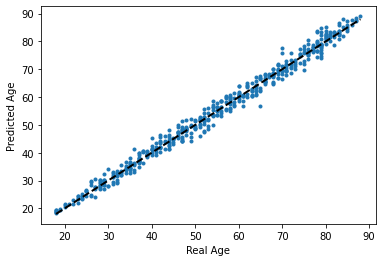

RMSE for Train Set: 2.0259 , MAE for Train Set: 1.5649


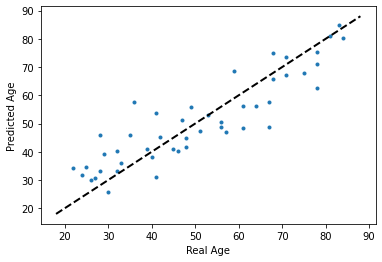

RMSE for Validation Set: 8.3666, MAE for Validation Set:6.8543


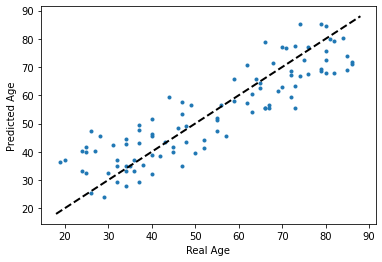

RMSE for Test Set: 9.0145, MAE for Test Set:7.5224


In [163]:
def eval(data_iter, model):
  
  model.eval()
  total_loss = 0
  total_sse = 0
  total_abserr = 0
  no_observations = 0
  actual = np.array([])
  predicted = np.array([])

  with torch.no_grad():

      for batch_idx, batch_samples in enumerate(data_iter):

            img, age = batch_samples['img'].to(device, dtype=dtype), batch_samples['age'].to(device, dtype=dtype)
            no_observations += img.size(0)
            prd = model(img)

            actual = np.concatenate((actual, age.cpu().flatten()))
            predicted = np.concatenate((predicted, prd.cpu().flatten()))

            total_loss += F.mse_loss(prd, age).item() # cumulative loss
            total_sse += np.sum((prd.detach().cpu().numpy() 
                                  - age.detach().cpu().numpy())**2) # cumulative sse
            total_abserr += np.sum(np.abs(prd.detach().cpu().numpy() 
                                   - age.detach().cpu().numpy())) # abs error
            
  fig, ax = plt.subplots()
  ax.scatter(actual, predicted, marker='.')
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  ax.set_xlabel('Real Age')
  ax.set_ylabel('Predicted Age')
  plt.show() 

  return total_loss/no_observations, total_sse/no_observations, np.sqrt(total_sse/ no_observations), total_abserr/no_observations

# Train set metrics
avg_loss_train, mse_train, rmse_train, mae_train = eval(dataloader_train, model)
print(f"RMSE for Train Set: {rmse_train:.4f} , MAE for Train Set: {mae_train:.4f}")

# Validation set metrics
avg_loss_valid, mse_valid, rmse_valid, mae_valid = eval(dataloader_valid, model)
print(f"RMSE for Validation Set: {rmse_valid:.4f}, MAE for Validation Set:{mae_valid:.4f}")

# Test set metrics:
avg_loss_test, mse_test, rmse_test, mae_test = eval(dataloader_test, model)
print(f"RMSE for Test Set: {rmse_test:.4f}, MAE for Test Set:{mae_test:.4f}")